Each paper has 2 samples for the same prompt / input.

In [1]:
from HF import *
import sys

In [13]:
from importlib import reload

import HF
reload(HF)
from HF import *

# 1010.1819.0

In [5]:
import numpy as np
from typing import Any
from scipy.signal import convolve

class HartreeFockHamiltonian:
  """
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  """
  def __init__(self, N_shell: int=1, parameters: dict={'gamma_0':1.0, 'gamma_1':1.0, 'gamma_3':1.0, 'gamma_4':1.0, 'V':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'triangular'
    self.D = (4,) # LM Task: has to define this tuple.
    self.basis_order = {'0': 'orbital'} # LM Task: Define which flavors to account for
    # this is the basis order that the Hamiltonian will follow
    # 0: orbital_0, orbital_1, orbital_2, orbital_3

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0 # LM Task: assume T = 0.
    self.k_space = generate_k_space(lattice=self.lattice, N_shell) # LM Task: Define the lattice.

    # All other parameters such as interaction strengths
    self.gamma_0 = parameters['gamma_0'] # Tight-binding model parameter.
    self.gamma_1 = parameters['gamma_1'] # Tight-binding model parameter.
    self.gamma_3 = parameters['gamma_3'] # Tight-binding model parameter.
    self.gamma_4 = parameters['gamma_4'] # Tight-binding model parameter.
    self.V = parameters['V'] # Interaction strength.
    self.aM = 1 # Lattice constant.
    # Any other problem specific parameters.

    return

  def generate_non_interacting(self) -> np.ndarray:
    """
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    """
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.complex128)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 1, :] = self.gamma_0*self.f(self.k_space) #gamma_0 f  c_0^\dagger c_1
    H_nonint[1, 0, :] = np.conjugate(H_nonint[0, 1, :]) #gamma_0 f^*  c_1^\dagger c_0

    H_nonint[0, 2, :] = self.gamma_4*self.f(self.k_space) #gamma_4 f  c_0^\dagger c_2
    H_nonint[2, 0, :] = np.conjugate(H_nonint[0, 2, :]) #gamma_4 f^*  c_2^\dagger c_0

    H_nonint[0, 3, :] = self.gamma_3*np.conjugate(self.f(self.k_space)) #gamma_3 f^*  c_0^\dagger c_3
    H_nonint[3, 0, :] = np.conjugate(H_nonint[0, 3, :]) #gamma_3 f  c_3^\dagger c_0

    H_nonint[1, 2, :] = self.gamma_1 #gamma_1  c_1^\dagger c_2
    H_nonint[2, 1, :] = np.conjugate(H_nonint[1, 2, :]) #gamma_1  c_2^\dagger c_1

    H_nonint[1, 3, :] = self.gamma_4*self.f(self.k_space) #gamma_4 f  c_1^\dagger c_3
    H_nonint[3, 1, :] = np.conjugate(H_nonint[1, 3, :]) #gamma_4 f^*  c_3^\dagger c_1

    H_nonint[2, 3, :] = self.gamma_0*self.f(self.k_space) #gamma_0 f  c_2^\dagger c_3
    H_nonint[3, 2, :] = np.conjugate(H_nonint[2, 3, :]) #gamma_0 f^*  c_3^\dagger c_2
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    """
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    """
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128)

    # Calculate the mean densities for spin up and spin down
    # Hartree Terms
    for lambda_1 in range(4):
      for lambda_2 in range(4):
        H_int[lambda_1, lambda_2, :] += self.V*np.mean(exp_val[lambda_1, lambda_2, :], axis=0)  
    # V*<c_{k_1,lambda_1}^\dagger c_{k_1,lambda_2}> c_{k_2,lambda_2}^\dagger c_{k_2,lambda_1}

    #Fock Terms
    for lambda_1 in range(4):
      for lambda_2 in range(4):
        temp =  -self.V*convolve(exp_val[lambda_1, lambda_2, :], self.V, mode='same')/self.aM
        H_int[lambda_1, lambda_2, :] += temp #-V(k_1-k_2)<c_{k_1,lambda_1}^\dagger c_{k_1,lambda_2}> c_{k_2,lambda_2}^\dagger c_{k_2,lambda_1}

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    """
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    """
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total #l1, s1, q1, ....k

  def f(self, k):
    return np.exp(1j*k[:, 1]*self.aM/np.sqrt(3))*(1 + 2*np.exp(-1j*3*k[:, 1]*self.aM/(2*np.sqrt(3)))*np.cos(k[:, 0]*self.aM/2))

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.k_space.shape[0]))

  def expand(self, exp_val):
    return exp_val.reshape((self.D[0],self.D[0], self.k_space.shape[0]))

SyntaxError: positional argument follows keyword argument (973327415.py, line 22)

# 1010.1819.1

In [6]:
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  """
  Args:
    N_kx (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
  """
  def __init__(self, N_kx: int=10, parameters: dict={'gamma_0':1.0, 'gamma_1':1.0, 'gamma_3':1.0, 'gamma_4':1.0, 'a':1.0, 'V':1.0}, filling_factor: float=0.5): #LM Task: Modify parameters
    self.lattice = 'triangular'   # Lattice symmetry ('square' or 'triangular').
    self.D = (4,) #LM Task: Define the tuple that contains the structure of the flavors.
    self.basis_order = {'0': 'orbital_0', '1':'orbital_1', '2':'orbital_2', '3':'orbital_3'} #LM Task: Define the basis order.
    # Order for each flavor:
    # 0: orbital 0
    # 1: orbital 1
    # 2: orbital 2
    # 3: orbital 3

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0 # Assume T = 0
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters #LM Task: Add model parameters with default values.
    self.gamma_0 = parameters['gamma_0'] # Tight-binding model parameter
    self.gamma_1 = parameters['gamma_1'] # Tight-binding model parameter
    self.gamma_3 = parameters['gamma_3'] # Tight-binding model parameter
    self.gamma_4 = parameters['gamma_4'] # Tight-binding model parameter
    self.a = parameters['a'] # Lattice constant
    self.V = parameters['V'] # Interaction strength
    self.A = self.a**2 # Area of the unit cell.

    return

  def generate_non_interacting(self) -> np.ndarray:
    """
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    """
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.complex128) #LM Task: Modify the code to match the basis order and number of flavors.

    # Define f(k)
    f = np.exp(1j * self.k_space[:, 1] * self.a / np.sqrt(3)) * (1 + 2 * np.exp(-1j * 3 * self.k_space[:, 1] * self.a / (2 * np.sqrt(3))) * np.cos(self.k_space[:, 0] * self.a / 2))

    # Populate the Hamiltonian matrix elements
    H_nonint[0, 1, :] = self.gamma_0 * f # <c_0^\dagger c_1>
    H_nonint[1, 0, :] = self.gamma_0 * np.conjugate(f) # <c_1^\dagger c_0>
    H_nonint[0, 2, :] = self.gamma_4 * f # <c_0^\dagger c_2>
    H_nonint[2, 0, :] = self.gamma_4 * np.conjugate(f) # <c_2^\dagger c_0>
    H_nonint[0, 3, :] = self.gamma_3 * np.conjugate(f) # <c_0^\dagger c_3>
    H_nonint[3, 0, :] = self.gamma_3 * f # <c_3^\dagger c_0>
    H_nonint[1, 3, :] = self.gamma_4 * f # <c_1^\dagger c_3>
    H_nonint[3, 1, :] = self.gamma_4 * np.conjugate(f) # <c_3^\dagger c_1>
    H_nonint[1, 2, :] = self.gamma_1 # <c_1^\dagger c_2>
    H_nonint[2, 1, :] = self.gamma_1 # <c_2^\dagger c_1>
    H_nonint[2, 3, :] = self.gamma_0 * f # <c_2^\dagger c_3>
    H_nonint[3, 2, :] = self.gamma_0 * np.conjugate(f) # <c_3^\dagger c_2>

    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    """
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    """
    exp_val = self.expand(exp_val) # D[0], D[0], N_k #LM Task: Modify the code to match the basis order and number of flavors.
    N_k = exp_val.shape[-1]
    H_int = np.zeros((self.D[0], self.D[0], N_k), dtype=np.complex128) #LM Task: Modify the code to match the basis order and number of flavors.

    for k in range(N_k):
      # Hartree Terms
      hartree_term = np.zeros((self.D[0], self.D[0]), dtype=np.complex128)
      for l in range(self.D[0]):
        hartree_term[l, l] =  np.sum(exp_val[l, l, k] * self.V / self.A)

      H_int[:,:, k] += hartree_term

      # Fock Terms
      fock_term = np.zeros((self.D[0], self.D[0]), dtype=np.complex128)
      for l in range(self.D[0]):
        for lp in range(self.D[0]):
          fock_term[lp, l] =  - (exp_val[l, lp, k] * self.V / self.A)

      H_int[:,:, k] += fock_term
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    """
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    """
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D[0],self.D[0], self.Nk)) #LM Task: Modify the code to match the basis order and number of flavors.

SyntaxError: positional argument follows keyword argument (647417116.py, line 25)

# Run all codes

In [3]:
def load_markdown(file):
    code_dict = {}
    current_paper = None  # Track the current task, initialized to None
    current_sample = None  # Track the current sample, initialized to None
    code_flag=False

    with open(file, 'r') as f:
        for line in f:
            stripped_line = line.strip()

            # Skip comments
            if stripped_line.startswith('<!--'):
                continue
            
            if stripped_line.startswith('# PAPER:'):
                # New task starts
                current_paper = stripped_line[2:].replace('PAPER: ','')

            if stripped_line.startswith('## Sample'):
                # New task starts
                current_sample = int(stripped_line[3:].replace('Sample ',''))
            
            if stripped_line==(r'```'):
                code_flag=False
                code_dict[current_paper,current_sample]=code

            if code_flag:
                code=code+line.replace(r'\"""',r'"""')
            
            if stripped_line==(r'```python'):
                code=''
                code_flag=True


    return code_dict

In [5]:
def load_markdown_2(file):
    """used to run 20240922"""
    code_dict = {}
    current_paper = None  # Track the current task, initialized to None
    current_sample = None  # Track the current sample, initialized to None
    code_flag=False
    code=''

    with open(file, 'r') as f:
        for line in f:
            stripped_line = line.strip()
            
            if stripped_line.startswith('# PAPER:'):
                if len(code)>0:
                    code_dict[current_paper,current_sample]=code
                    code= ''
                current_paper = stripped_line[2:].replace('PAPER: ','')
            elif stripped_line.startswith('## Sample'):
                if len(code)>0:
                    code_dict[current_paper,current_sample]=code
                    code= ''
                current_sample = int(stripped_line[3:].replace('Sample ',''))
            else:
                code=code+line.replace(r'\"""',r'"""')
        code_dict[current_paper,current_sample]=code


    return code_dict

In [6]:
dd=load_markdown_2('Dataset_v2_Outputs/20240922.md')

In [7]:
(dd.keys())

dict_keys([('1010.1819', 0), ('1010.1819', 1), ('1106.606', 0), ('1106.606', 1), ('1208.0116', 0), ('1208.0116', 1), ('1310.2674', 0), ('1310.2674', 1), ('1508.00296', 0), ('1508.00296', 1), ('1812.04213', 0), ('1812.04213', 1), ('2004.04168', 0), ('2004.04168', 1), ('2008.08998', 0), ('2008.08998', 1), ('2012.04554', 0), ('2012.04554', 1), ('2108.02159', 0), ('2108.02159', 1), ('2110.1133', 0), ('2110.1133', 1), ('2111.01152', 0), ('2111.01152', 1), ('2112.07523', 0), ('2112.07523', 1), ('2308.03843', 0), ('2308.03843', 1), ('2308.07488', 0), ('2308.07488', 1)])

In [ ]:
print(dd[('2308.07488', 0)])

In [55]:
len(dd.keys())

30

In [44]:
exec(dd[('1010.1819', 0)])

SyntaxError: positional argument follows keyword argument (<string>, line 22)

In [61]:
for key,val in dd.items():
    directory = 'Dataset_v2_Outputs'
    filename=os.path.join(directory,f"code_{key[0].replace('.','_')}_{key[1]}.py")
    print(filename)
    with open(filename,'w') as f:
        val = 'from HF import *\n' + val
        f.write(val)

Dataset_v2_Outputs/code_1010_1819_0.py
Dataset_v2_Outputs/code_1010_1819_1.py
Dataset_v2_Outputs/code_1106_606_0.py
Dataset_v2_Outputs/code_1106_606_1.py
Dataset_v2_Outputs/code_1208_0116_0.py
Dataset_v2_Outputs/code_1208_0116_1.py
Dataset_v2_Outputs/code_1310_2674_0.py
Dataset_v2_Outputs/code_1310_2674_1.py
Dataset_v2_Outputs/code_1508_00296_0.py
Dataset_v2_Outputs/code_1508_00296_1.py
Dataset_v2_Outputs/code_1812_04213_0.py
Dataset_v2_Outputs/code_1812_04213_1.py
Dataset_v2_Outputs/code_2004_04168_0.py
Dataset_v2_Outputs/code_2004_04168_1.py
Dataset_v2_Outputs/code_2008_08998_0.py
Dataset_v2_Outputs/code_2008_08998_1.py
Dataset_v2_Outputs/code_2012_04554_0.py
Dataset_v2_Outputs/code_2012_04554_1.py
Dataset_v2_Outputs/code_2108_02159_0.py
Dataset_v2_Outputs/code_2108_02159_1.py
Dataset_v2_Outputs/code_2110_1133_0.py
Dataset_v2_Outputs/code_2110_1133_1.py
Dataset_v2_Outputs/code_2111_01152_0.py
Dataset_v2_Outputs/code_2111_01152_1.py
Dataset_v2_Outputs/code_2112_07523_0.py
Dataset_v2_O

In [8]:
import pandas as pd

In [116]:
import importlib.util


In [17]:
truth_table = pd.DataFrame({},columns=[0,1])
ham={}
for key,val in dd.items():
    # print(key)
    try:
        # exec(val)
        exec(val+'ham=HartreeFockHamiltonian()')

        # filename=os.path.join(directory,f"code_{key[0].replace('.','_')}_{key[1]}.py")
        # # from filename import HartreeFockHamiltonian
        # spec = importlib.util.spec_from_file_location("HartreeFockHamiltonian", filename)
        # module = importlib.util.module_from_spec(spec)
        # spec.loader.exec_module(module)
        # ham[key]=HartreeFockHamiltonian()
    except Exception as e:
        print(f"Error executing code for {key}: {e}")
        truth_table.loc[key] = False
        pass
    else:
        print(f"Successfully executed code for {key}.")
        truth_table.loc[key] = True
    

Successfully executed code for ('1010.1819', 0).
Successfully executed code for ('1010.1819', 1).
Successfully executed code for ('1106.606', 0).
Successfully executed code for ('1106.606', 1).
Successfully executed code for ('1208.0116', 0).
Successfully executed code for ('1208.0116', 1).
Error executing code for ('1310.2674', 0): Unsupported lattice: cubic
Error executing code for ('1310.2674', 1): Unsupported lattice: cubic
Error executing code for ('1508.00296', 0): invalid syntax (<string>, line 48)
Successfully executed code for ('1508.00296', 1).
Successfully executed code for ('1812.04213', 0).
Successfully executed code for ('1812.04213', 1).
Error executing code for ('2004.04168', 0): index 7 is out of bounds for axis 0 with size 7
Error executing code for ('2004.04168', 1): index 7 is out of bounds for axis 0 with size 7
Error executing code for ('2008.08998', 0): index 7 is out of bounds for axis 0 with size 7
Error executing code for ('2008.08998', 1): index 331 is out of

In [18]:
truth_table

,0,1
1010.1819,True,True
1106.606,True,True
1208.0116,True,True
1310.2674,False,False
1508.00296,False,True
1812.04213,True,True
2004.04168,False,False
2008.08998,False,False
2012.04554,False,False
2108.02159,False,True


In [ ]:
((truth_table.loc[:,0]) | (truth_table.loc[:,1])).sum()

In [20]:
(truth_table.loc[:,0] + truth_table.loc[:,1]).sum()

13

In [86]:
truth_table.sum()

0    4
1    7
dtype: object

In [66]:
import pandas as pd

# Artifect test individual

In [1]:
import sys
sys.path.append('Dataset_v2_Outputs')

In [2]:
import matplotlib.pyplot as plt

# 1010.1819

In [5]:
import code_1010_1819_0 
ham=code_1010_1819_0.HartreeFockHamiltonian()

In [ ]:
ham.k_space

(-0.4821633369868303,
 1.613618140171511,
 -1.0478907385791707,
 1.0478907385791707)

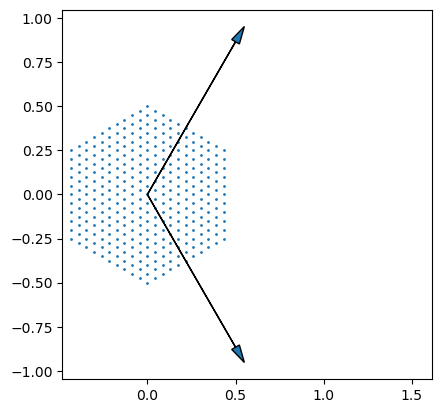

In [20]:
plt.scatter(ham.k_space[:,0],ham.k_space[:,1],s=1)

plt.arrow(0,0,vec[0,0],vec[0,1],head_width=0.05, head_length=0.1)
plt.arrow(0,0,vec[1,0],vec[1,1],head_width=0.05, head_length=0.1)
plt.axis('square')

In [12]:
4*np.pi/(3)

4.1887902047863905

In [14]:
vec=get_reciprocal_vectors()

In [27]:
import code_1010_1819_1 
ham=code_1010_1819_1.HartreeFockHamiltonian()

(-0.4821633369868303,
 1.613618140171511,
 -1.0478907385791707,
 1.0478907385791707)

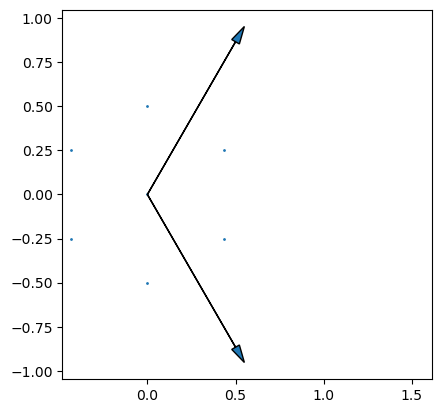

In [22]:
plt.scatter(ham.k_space[:,0],ham.k_space[:,1],s=1)

plt.arrow(0,0,vec[0,0],vec[0,1],head_width=0.05, head_length=0.1)
plt.arrow(0,0,vec[1,0],vec[1,1],head_width=0.05, head_length=0.1)
plt.axis('square')

# 1106.6060

In [25]:
import code_1106_606_0 
ham=code_1106_606_0.HartreeFockHamiltonian()

(-3.440791953931678,
 3.1415926535897936,
 -3.440791953931678,
 3.1415926535897936)

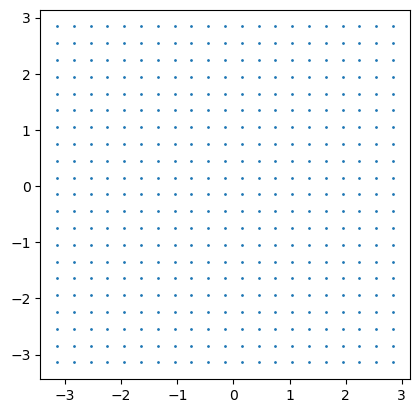

In [28]:
plt.scatter(ham.k_space[:,0],ham.k_space[:,1],s=1)

# plt.arrow(0,0,vec[0,0],vec[0,1],head_width=0.05, head_length=0.1)
# plt.arrow(0,0,vec[1,0],vec[1,1],head_width=0.05, head_length=0.1)
plt.axis('square')

In [29]:
ham.generate_non_interacting()

IndexError: too many indices for array: array is 3-dimensional, but 7 were indexed

In [32]:
import code_1106_606_1 
ham=code_1106_606_1.HartreeFockHamiltonian()

(-3.3510321638291125,
 1.2566370614359168,
 -3.3510321638291125,
 1.2566370614359168)

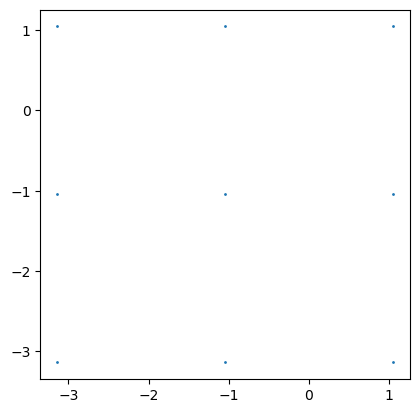

In [33]:
plt.scatter(ham.k_space[:,0],ham.k_space[:,1],s=1)

# plt.arrow(0,0,vec[0,0],vec[0,1],head_width=0.05, head_length=0.1)
# plt.arrow(0,0,vec[1,0],vec[1,1],head_width=0.05, head_length=0.1)
plt.axis('square')

In [34]:
ham.generate_non_interacting()

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

# 1208.0116

In [35]:
import code_1208_0116_0 
ham=code_1208_0116_0.HartreeFockHamiltonian()

(-0.4821633369868303,
 1.613618140171511,
 -1.0478907385791707,
 1.0478907385791707)

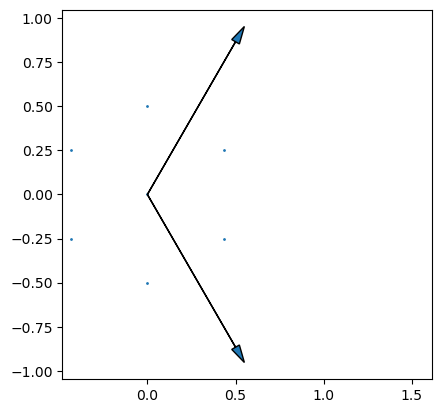

In [36]:
plt.scatter(ham.k_space[:,0],ham.k_space[:,1],s=1)

plt.arrow(0,0,vec[0,0],vec[0,1],head_width=0.05, head_length=0.1)
plt.arrow(0,0,vec[1,0],vec[1,1],head_width=0.05, head_length=0.1)
plt.axis('square')

In [37]:
import code_1208_0116_1 
ham=code_1208_0116_1.HartreeFockHamiltonian()

(-0.4821633369868303,
 1.613618140171511,
 -1.0478907385791707,
 1.0478907385791707)

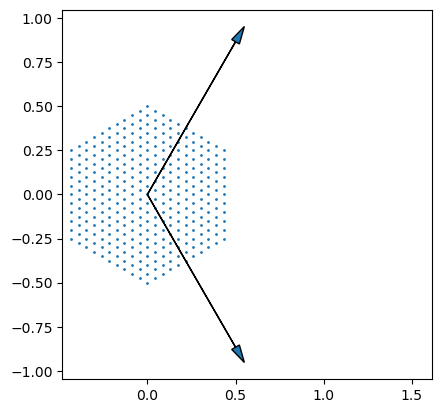

In [38]:
plt.scatter(ham.k_space[:,0],ham.k_space[:,1],s=1)

plt.arrow(0,0,vec[0,0],vec[0,1],head_width=0.05, head_length=0.1)
plt.arrow(0,0,vec[1,0],vec[1,1],head_width=0.05, head_length=0.1)
plt.axis('square')

In [ ]:
ham.generate_non_interacting()

# 1508.00296	

In [ ]:
exec(dd[('1508.00296',0)])

# 2004.04168

In [49]:
import code_2004_04168_0 
ham=code_2004_04168_0.HartreeFockHamiltonian()

IndexError: index 7 is out of bounds for axis 0 with size 7

In [46]:
generate_k_space(lattice='triangular', N_shell=1)

array([[-3.06161700e-17,  5.00000000e-01],
       [ 4.33012702e-01,  2.50000000e-01],
       [-4.33012702e-01,  2.50000000e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 4.33012702e-01, -2.50000000e-01],
       [-4.33012702e-01, -2.50000000e-01],
       [ 3.06161700e-17, -5.00000000e-01]])

In [8]:
ham.k_space[0]

array([-3.14159265, -3.14159265])

In [43]:
import code_2004_04168_1 
ham=code_2004_04168_1.HartreeFockHamiltonian()

TypeError: 'float' object is not subscriptable

# 2012.04554

In [52]:
import code_2012_04554_0
ham=code_2012_04554_0.HartreeFockHamiltonian()

AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
ham=HartreeFockHamiltonian()

In [5]:
ham.k_space[0]

array([-3.14159265, -3.14159265])

In [53]:
import code_2012_04554_1
ham=code_2012_04554_1.HartreeFockHamiltonian()

(-0.4821633369868303,
 1.613618140171511,
 -1.0478907385791707,
 1.0478907385791707)

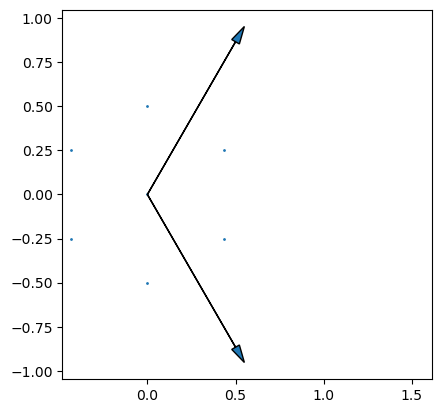

In [54]:
plt.scatter(ham.k_space[:,0],ham.k_space[:,1],s=1)

plt.arrow(0,0,vec[0,0],vec[0,1],head_width=0.05, head_length=0.1)
plt.arrow(0,0,vec[1,0],vec[1,1],head_width=0.05, head_length=0.1)
plt.axis('square')

# GPT-4o

In [3]:
import code_1106_606_2
ham=code_1106_606_2.HartreeFockHamiltonian()

(-3.440791953931678,
 3.1415926535897927,
 -3.440791953931678,
 3.1415926535897927)

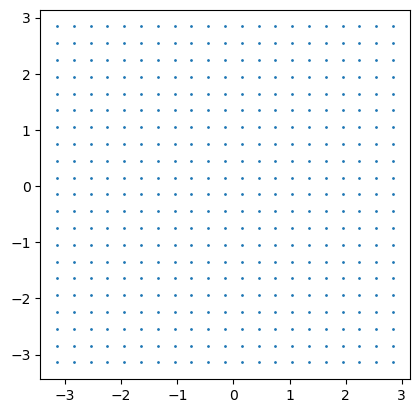

In [4]:
plt.scatter(ham.k_space[:,0],ham.k_space[:,1],s=1)

# plt.arrow(0,0,vec[0,0],vec[0,1],head_width=0.05, head_length=0.1)
# plt.arrow(0,0,vec[1,0],vec[1,1],head_width=0.05, head_length=0.1)
plt.axis('square')

In [8]:
ham.generate_non_interacting().shape

(2, 3, 2, 3, 441)

In [9]:
Ek=ham.generate_non_interacting()

In [11]:
from HF import diagonalize

In [13]:
wf,en=diagonalize(ham.generate_non_interacting().reshape(6,6,-1))

In [14]:
en.shape

(6, 441)

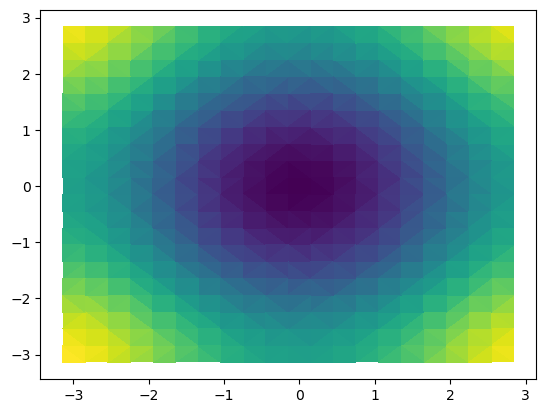

In [15]:
plt.tripcolor(ham.k_space[:,0],ham.k_space[:,1],en[0])

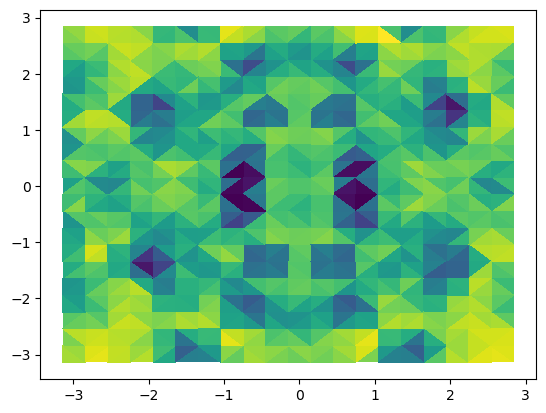

In [16]:
plt.tripcolor(ham.k_space[:,0],ham.k_space[:,1],en[1])

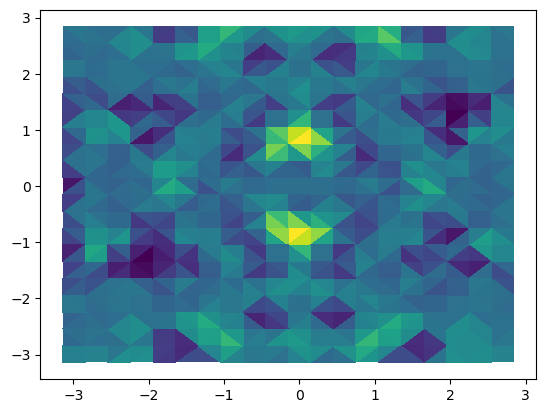

In [17]:
plt.tripcolor(ham.k_space[:,0],ham.k_space[:,1],en[2])

In [ ]:
z

## Symmetry check

In [5]:
def test_rotational_symmetry(model):
  valid_sym_rot, _ = map_lattice_geom_to_valid_symmetries(model)
  success = []
  # Order: C2, C3, C4, C6
  for rsym in ['C2', 'C3', 'C4', 'C6']:
    is_sym = check_rotation(model, rsym)
    if rsym in valid_sym_rot and not is_sym:
      raise PhysicsError(
          'The model should be rotationally symmetric under', rsym
      )
    elif rsym not in valid_sym_rot and is_sym:
      raise PhysicsError(
          f'The model is rotationally symmetric under {rsym} though it should'
          ' not be.'
      )
    elif is_sym:
      success.append(rsym)
    else:
      pass
  msg = "Is rotationally symmetric under:" + str(success)
  print(msg)
  return msg

In [6]:
from sanity_check import *

In [7]:
def rotation_check():
  hamiltonian = code_1106_606_2.HartreeFockHamiltonian()
  test_rotational_symmetry(hamiltonian)
  return
out = rotation_check()

PhysicsError: ('The model should be rotationally symmetric under', 'C4')

# PAPER: 1010.1819
## Sample 0
ANSWER:
1) Number of Flavors, D = (4,)
Basis Order:
0: orbital. Order: 0, 1, 2, 3

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle c_{k_1,0}^\dagger c_{k_1,0} \rangle": "`exp_val[0, 0, :]`",
    r"\langle c_{k_1,1}^\dagger c_{k_1,1} \rangle": "`exp_val[1, 1, :]`",
    r"\langle c_{k_1,2}^\dagger c_{k_1,2} \rangle": "`exp_val[2, 2, :]`",
    r"\langle c_{k_1,3}^\dagger c_{k_1,3} \rangle": "`exp_val[3, 3, :]`",
    r"\langle c_{k_1,0}^\dagger c_{k_1,1} \rangle": "`exp_val[0, 1, :]`",
    r"\langle c_{k_1,0}^\dagger c_{k_1,2} \rangle": "`exp_val[0, 2, :]`",
    r"\langle c_{k_1,0}^\dagger c_{k_1,3} \rangle": "`exp_val[0, 3, :]`",
    r"\langle c_{k_1,1}^\dagger c_{k_1,0} \rangle": "`exp_val[1, 0, :]`",
    r"\langle c_{k_1,1}^\dagger c_{k_1,2} \rangle": "`exp_val[1, 2, :]`",
    r"\langle c_{k_1,1}^\dagger c_{k_1,3} \rangle": "`exp_val[1, 3, :]`",
    r"\langle c_{k_1,2}^\dagger c_{k_1,0} \rangle": "`exp_val[2, 0, :]`",
    r"\langle c_{k_1,2}^\dagger c_{k_1,1} \rangle": "`exp_val[2, 1, :]`",
    r"\langle c_{k_1,2}^\dagger c_{k_1,3} \rangle": "`exp_val[2, 3, :]`",
    r"\langle c_{k_1,3}^\dagger c_{k_1,0} \rangle": "`exp_val[3, 0, :]`",
    r"\langle c_{k_1,3}^\dagger c_{k_1,1} \rangle": "`exp_val[3, 1, :]`",
    r"\langle c_{k_1,3}^\dagger c_{k_1,2} \rangle": "`exp_val[3, 2, :]`"}
  
  TERMS:
    $\gamma_0 f c_{k,0}^\dagger c_{k,1}$ -> H[0, 1, k], NI
    $\gamma_0 f^* c_{k,1}^\dagger c_{k,0}$ -> H[1, 0, k], NI
    $\gamma_4 f c_{k,0}^\dagger c_{k,2}$ -> H[0, 2, k], NI
    $\gamma_4 f^* c_{k,2}^\dagger c_{k,0}$ -> H[2, 0, k], NI
    $\gamma_3 f^* c_{k,0}^\dagger c_{k,3}$ -> H[0, 3, k], NI
    $\gamma_3 f c_{k,3}^\dagger c_{k,0}$ -> H[3, 0, k], NI
    $\gamma_1 c_{k,1}^\dagger c_{k,2}$ -> H[1, 2, k], NI
    $\gamma_1 c_{k,2}^\dagger c_{k,1}$ -> H[2, 1, k], NI
    $\gamma_4 f c_{k,1}^\dagger c_{k,3}$ -> H[1, 3, k], NI
    $\gamma_4 f^* c_{k,3}^\dagger c_{k,1}$ -> H[3, 1, k], NI
    $\gamma_0 f c_{k,2}^\dagger c_{k,3}$ -> H[2, 3, k], NI
    $\gamma_0 f^* c_{k,3}^\dagger c_{k,2}$ -> H[3, 2, k], NI
    $V^{HF}_{quadratic}$ -> All elements of H[d, d', k], I


3) CODE:
```python
import numpy as np
from typing import Any
from scipy.signal import convolve

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=1, parameters: dict={'gamma_0':1.0, 'gamma_1':1.0, 'gamma_3':1.0, 'gamma_4':1.0, 'V':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'triangular'
    self.D = (4,) # LM Task: has to define this tuple.
    self.basis_order = {'0': 'orbital'} # LM Task: Define which flavors to account for
    # this is the basis order that the Hamiltonian will follow
    # 0: orbital_0, orbital_1, orbital_2, orbital_3

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0 # LM Task: assume T = 0.
    self.k_space = generate_k_space(lattice=self.lattice, N_shell) # LM Task: Define the lattice.

    # All other parameters such as interaction strengths
    self.gamma_0 = parameters['gamma_0'] # Tight-binding model parameter.
    self.gamma_1 = parameters['gamma_1'] # Tight-binding model parameter.
    self.gamma_3 = parameters['gamma_3'] # Tight-binding model parameter.
    self.gamma_4 = parameters['gamma_4'] # Tight-binding model parameter.
    self.V = parameters['V'] # Interaction strength.
    self.aM = 1 # Lattice constant.
    # Any other problem specific parameters.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.complex128)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 1, :] = self.gamma_0*self.f(self.k_space) #gamma_0 f  c_0^\dagger c_1
    H_nonint[1, 0, :] = np.conjugate(H_nonint[0, 1, :]) #gamma_0 f^*  c_1^\dagger c_0

    H_nonint[0, 2, :] = self.gamma_4*self.f(self.k_space) #gamma_4 f  c_0^\dagger c_2
    H_nonint[2, 0, :] = np.conjugate(H_nonint[0, 2, :]) #gamma_4 f^*  c_2^\dagger c_0

    H_nonint[0, 3, :] = self.gamma_3*np.conjugate(self.f(self.k_space)) #gamma_3 f^*  c_0^\dagger c_3
    H_nonint[3, 0, :] = np.conjugate(H_nonint[0, 3, :]) #gamma_3 f  c_3^\dagger c_0

    H_nonint[1, 2, :] = self.gamma_1 #gamma_1  c_1^\dagger c_2
    H_nonint[2, 1, :] = np.conjugate(H_nonint[1, 2, :]) #gamma_1  c_2^\dagger c_1

    H_nonint[1, 3, :] = self.gamma_4*self.f(self.k_space) #gamma_4 f  c_1^\dagger c_3
    H_nonint[3, 1, :] = np.conjugate(H_nonint[1, 3, :]) #gamma_4 f^*  c_3^\dagger c_1

    H_nonint[2, 3, :] = self.gamma_0*self.f(self.k_space) #gamma_0 f  c_2^\dagger c_3
    H_nonint[3, 2, :] = np.conjugate(H_nonint[2, 3, :]) #gamma_0 f^*  c_3^\dagger c_2
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128)

    # Calculate the mean densities for spin up and spin down
    # Hartree Terms
    for lambda_1 in range(4):
      for lambda_2 in range(4):
        H_int[lambda_1, lambda_2, :] += self.V*np.mean(exp_val[lambda_1, lambda_2, :], axis=0)  
    # V*<c_{k_1,lambda_1}^\dagger c_{k_1,lambda_2}> c_{k_2,lambda_2}^\dagger c_{k_2,lambda_1}

    #Fock Terms
    for lambda_1 in range(4):
      for lambda_2 in range(4):
        temp =  -self.V*convolve(exp_val[lambda_1, lambda_2, :], self.V, mode='same')/self.aM
        H_int[lambda_1, lambda_2, :] += temp #-V(k_1-k_2)<c_{k_1,lambda_1}^\dagger c_{k_1,lambda_2}> c_{k_2,lambda_2}^\dagger c_{k_2,lambda_1}

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total #l1, s1, q1, ....k

  def f(self, k):
    return np.exp(1j*k[:, 1]*self.aM/np.sqrt(3))*(1 + 2*np.exp(-1j*3*k[:, 1]*self.aM/(2*np.sqrt(3)))*np.cos(k[:, 0]*self.aM/2))

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.k_space.shape[0]))

  def expand(self, exp_val):
    return exp_val.reshape((self.D[0],self.D[0], self.k_space.shape[0]))
```
## Sample 1
ANSWER:
1) Number of Flavors, D = 4
Basis Order:
0: orbital_0
1: orbital_1
2: orbital_2
3: orbital_3

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle c_{k_1,\lambda}^\dagger c_{k_1,\lambda} \rangle": "Diagonal of `exp_val[:,:,k]`",
    r"\langle c_{k_1,\lambda}^\dagger c_{k_1,\lambda^\prime} \rangle": "`exp_val[:,:,k]`"}

  TERMS:
    $\gamma_0 f$ -> H[0, 1, k], NI
    $\gamma_0 f^*$ -> H[1, 0, k], NI
    $\gamma_4 f$ -> H[0, 2, k], NI
    $\gamma_4 f^*$ -> H[2, 0, k], NI
    $\gamma_3 f^*$ -> H[0, 3, k], NI
    $\gamma_3 f$ -> H[3, 0, k], NI
    $\gamma_4 f$ -> H[1, 3, k], NI
    $\gamma_4 f^*$ -> H[3, 1, k], NI
    $\gamma_1$ -> H[1, 2, k], NI
    $\gamma_1$ -> H[2, 1, k], NI
    $\gamma_0 f$ -> H[2, 3, k], NI
    $\gamma_0 f^*$ -> H[3, 2, k], NI
    $\frac{1}{A} \sum_{\lambda, \lambda^{\prime}, k_1, k_2}  \langle c_{k_1,\lambda}^\dagger c_{k_1,\lambda} \rangle c_{k_2,\lambda^{\prime}}^\dagger c_{k_2,\lambda^{\prime}}  \times V(0)$ -> H[0, 0, k], H[1, 1, k], H[2, 2, k], H[3, 3, k], I
    $- \frac{1}{A} \sum_{\lambda, \lambda^{\prime}, k_1, k_2}  \langle c_{k_1,\lambda}^\dagger c_{k_1,\lambda^{\prime}} \rangle c_{k_2,\lambda^{\prime}}^\dagger c_{k_2,\lambda}  \times V(k_1-k_2)$ -> H[0, 0, k], H[0, 1, k], H[0, 2, k], H[0, 3, k], H[1, 0, k], H[1, 1, k], H[1, 2, k], H[1, 3, k], H[2, 0, k], H[2, 1, k], H[2, 2, k], H[2, 3, k], H[3, 0, k], H[3, 1, k], H[3, 2, k], H[3, 3, k], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_kx (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
  \"""
  def __init__(self, N_kx: int=10, parameters: dict={'gamma_0':1.0, 'gamma_1':1.0, 'gamma_3':1.0, 'gamma_4':1.0, 'a':1.0, 'V':1.0}, filling_factor: float=0.5): #LM Task: Modify parameters
    self.lattice = 'triangular'   # Lattice symmetry ('square' or 'triangular').
    self.D = (4,) #LM Task: Define the tuple that contains the structure of the flavors.
    self.basis_order = {'0': 'orbital_0', '1':'orbital_1', '2':'orbital_2', '3':'orbital_3'} #LM Task: Define the basis order.
    # Order for each flavor:
    # 0: orbital 0
    # 1: orbital 1
    # 2: orbital 2
    # 3: orbital 3

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0 # Assume T = 0
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters #LM Task: Add model parameters with default values.
    self.gamma_0 = parameters['gamma_0'] # Tight-binding model parameter
    self.gamma_1 = parameters['gamma_1'] # Tight-binding model parameter
    self.gamma_3 = parameters['gamma_3'] # Tight-binding model parameter
    self.gamma_4 = parameters['gamma_4'] # Tight-binding model parameter
    self.a = parameters['a'] # Lattice constant
    self.V = parameters['V'] # Interaction strength
    self.A = self.a**2 # Area of the unit cell.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.complex128) #LM Task: Modify the code to match the basis order and number of flavors.

    # Define f(k)
    f = np.exp(1j * self.k_space[:, 1] * self.a / np.sqrt(3)) * (1 + 2 * np.exp(-1j * 3 * self.k_space[:, 1] * self.a / (2 * np.sqrt(3))) * np.cos(self.k_space[:, 0] * self.a / 2))

    # Populate the Hamiltonian matrix elements
    H_nonint[0, 1, :] = self.gamma_0 * f # <c_0^\dagger c_1>
    H_nonint[1, 0, :] = self.gamma_0 * np.conjugate(f) # <c_1^\dagger c_0>
    H_nonint[0, 2, :] = self.gamma_4 * f # <c_0^\dagger c_2>
    H_nonint[2, 0, :] = self.gamma_4 * np.conjugate(f) # <c_2^\dagger c_0>
    H_nonint[0, 3, :] = self.gamma_3 * np.conjugate(f) # <c_0^\dagger c_3>
    H_nonint[3, 0, :] = self.gamma_3 * f # <c_3^\dagger c_0>
    H_nonint[1, 3, :] = self.gamma_4 * f # <c_1^\dagger c_3>
    H_nonint[3, 1, :] = self.gamma_4 * np.conjugate(f) # <c_3^\dagger c_1>
    H_nonint[1, 2, :] = self.gamma_1 # <c_1^\dagger c_2>
    H_nonint[2, 1, :] = self.gamma_1 # <c_2^\dagger c_1>
    H_nonint[2, 3, :] = self.gamma_0 * f # <c_2^\dagger c_3>
    H_nonint[3, 2, :] = self.gamma_0 * np.conjugate(f) # <c_3^\dagger c_2>

    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # D[0], D[0], N_k #LM Task: Modify the code to match the basis order and number of flavors.
    N_k = exp_val.shape[-1]
    H_int = np.zeros((self.D[0], self.D[0], N_k), dtype=np.complex128) #LM Task: Modify the code to match the basis order and number of flavors.

    for k in range(N_k):
      # Hartree Terms
      hartree_term = np.zeros((self.D[0], self.D[0]), dtype=np.complex128)
      for l in range(self.D[0]):
        hartree_term[l, l] =  np.sum(exp_val[l, l, k] * self.V / self.A)

      H_int[:,:, k] += hartree_term

      # Fock Terms
      fock_term = np.zeros((self.D[0], self.D[0]), dtype=np.complex128)
      for l in range(self.D[0]):
        for lp in range(self.D[0]):
          fock_term[lp, l] =  - (exp_val[l, lp, k] * self.V / self.A)

      H_int[:,:, k] += fock_term
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D[0],self.D[0], self.Nk)) #LM Task: Modify the code to match the basis order and number of flavors.
```

# PAPER: 1106.606
## Sample 0
ANSWER:

1) Number of Flavors, D = (2, 3)
Basis Order:
0: spin. Order: spin up, spin down
1: orbital. Order: p_x, p_y, d

2) EXP-VAL DEPENDENT TERMS: {
    r"n": "`np.mean(np.sum(exp_val, axis=(0, 1), keepdims=True), axis=-1)`",
    r"n_x^p": "`np.mean(exp_val[0, 0, :] + exp_val[1, 0, :])`",
    r"n_y^p": "`np.mean(exp_val[0, 1, :] + exp_val[1, 1, :])`",
    r"n^p": "`n_x^p` + `n_y^p`",
    r"eta": "`n_y^p` - `n_x^p`"
}
  
  TERMS:
    $\xi_{x} \hat{p}^{\dag}_{x\kk s}\hat{p}^{\phantom{\dag}}_{x\kk s}$ -> H[s, 0, s, 0, k], I
    $\xi_{y} \hat{p}^{\dag}_{y\kk s}\hat{p}^{\phantom{\dag}}_{y\kk s}$ -> H[s, 1, s, 1, k], I
    $\xi_{d} \hat{d}^{\dag}_{\kk s}\hat{d}^{\phantom{\dag}}_{\kk s}$ -> H[s, 2, s, 2, k], I
    $\gamma_2(\kk) \hat{p}^{\dag}_{x\kk s}\hat{p}^{\phantom{\dag}}_{y\kk s}$ -> H[s, 0, s, 1, k], NI
    $\gamma_2(\kk) \hat{p}^{\dag}_{y\kk s}\hat{p}^{\phantom{\dag}}_{x\kk s}$ -> H[s, 1, s, 0, k], NI
    $\gamma_1(k_x) \hat{p}^{\dag}_{x\kk s}\hat{d}^{\phantom{\dag}}_{\kk s}$ -> H[s, 0, s, 2, k], NI
    $\gamma_1(k_x) \hat{d}^{\dag}_{\kk s}\hat{p}^{\phantom{\dag}}_{x\kk s}$ -> H[s, 2, s, 0, k], NI
    $\gamma_1(k_y) \hat{p}^{\dag}_{y\kk s}\hat{d}^{\phantom{\dag}}_{\kk s}$ -> H[s, 1, s, 2, k], NI
    $\gamma_1(k_y) \hat{d}^{\dag}_{\kk s}\hat{p}^{\phantom{\dag}}_{y\kk s}$ -> H[s, 2, s, 1, k], NI
    $f(n^{p}, \eta)$ -> All diagonal elements, I


3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  The Hartree-Fock Hamiltonian for a 2D system with three orbitals (px, py, d)
  and spin degeneracy. The Hamiltonian is given by:
  H = H_0 + H_int,
  where H_0 is the non-interacting part and H_int is the interacting part.

  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters
        't_pd', 't_pp', 'Delta', 'U_p', 'V_pp', 'U_d', 'V_pd'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'t_pd':1.0, 't_pp': 0.5, 'Delta':1.0, 'U_p': 1.0, 'V_pp':0.4, 'U_d': 1.0, 'V_pd': 0.2}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'
    self.D = (2, 3) # (spin, orbital)
    self.basis_order = {'0': 'spin', '1':'orbital'}
    # Order for each flavor:
    # 0: spin up, spin down
    # 1: p_x, p_y, d

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)

    # Model parameters
    self.t_pd = parameters['t_pd'] # Hopping between p and d orbitals.
    self.t_pp = parameters['t_pp'] # Hopping between p orbitals.
    self.Delta = parameters['Delta'] # Crystal field splitting.
    self.U_p = parameters['U_p'] # On-site interaction on p orbital.
    self.V_pp = parameters['V_pp'] # Nearest-neighbour interaction between p orbitals.
    self.U_d = parameters['U_d'] # On-site interaction on d orbital.
    self.V_pd = parameters['V_pd'] # Nearest-neighbour interaction between p and d orbitals.

    # Effective interaction parameters.
    self.U_p_tilde = self.U_p + 8 * self.V_pp - 8 * self.V_pd
    self.V_pp_tilde = 8 * self.V_pp - self.U_p
    self.U_d_tilde = self.U_d - 4 * self.V_pd

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    
    # Define hopping terms.
    gamma_1_x = -2 * self.t_pd * np.cos(self.k_space[:, 0] / 2)
    gamma_1_y = -2 * self.t_pd * np.cos(self.k_space[:, 1] / 2)
    gamma_2 = -4 * self.t_pp * np.cos(self.k_space[:, 0] / 2) * np.cos(self.k_space[:, 1] / 2)

    # Assign matrix elements for both spins.
    for s in range(2):
        # Assign diagonal elements of kinetic energy
        H_nonint[s, 0, s, 0, :] = self.Delta # p_x, p_x
        H_nonint[s, 1, s, 1, :] = self.Delta # p_y, p_y
        
        # Assign off-diagonal elements of kinetic energy
        H_nonint[s, 0, s, 1, :] = gamma_2 # p_x, p_y
        H_nonint[s, 1, s, 0, :] = gamma_2 # p_y, p_x

        H_nonint[s, 0, s, 2, :] = gamma_1_x # p_x, d
        H_nonint[s, 2, s, 0, :] = gamma_1_x # d, p_x

        H_nonint[s, 1, s, 2, :] = gamma_1_y # p_y, d
        H_nonint[s, 2, s, 1, :] = gamma_1_y # d, p_y
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val)
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    
    # Calculate relevant densities.
    n = np.mean(np.sum(exp_val, axis=(0, 1), keepdims=True), axis=-1)
    n_x_p = np.mean(exp_val[0, 0, :] + exp_val[1, 0, :]) # p_x orbital
    n_y_p = np.mean(exp_val[0, 1, :] + exp_val[1, 1, :]) # p_y orbital
    n_p = n_x_p + n_y_p
    eta = n_y_p - n_x_p

    # Calculate diagonal elements of interaction energy
    xi_x = self.Delta + (self.U_p_tilde * n_p / 4) - (self.V_pp_tilde * eta / 4)
    xi_y = self.Delta + (self.U_p_tilde * n_p / 4) + (self.V_pp_tilde * eta / 4)
    xi_d = (self.U_d_tilde * (n - n_p) / 2)

    # Calculate the constant term
    f = (-self.U_p_tilde * n_p**2 / 8) + (self.V_pp_tilde * eta**2 / 8) - (self.U_d_tilde * (n - n_p)**2 / 4)
    
    # Assign matrix elements for both spins.
    for s in range(2):
        H_int[s, 0, s, 0, :] = xi_x # p_x, p_x
        H_int[s, 1, s, 1, :] = xi_y # p_y, p_y
        H_int[s, 2, s, 2, :] = xi_d # d, d

        # Adding constant energy contribution
        H_int[s, 0, s, 0, :] +=  f # p_x, p_x
        H_int[s, 1, s, 1, :] +=  f # p_y, p_y
        H_int[s, 2, s, 2, :] +=  f # d, d
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```
## Sample 1
ANSWER:

1) Number of Flavors, D = (2, 3)
Basis Order:
0: spin. Order: spin up, spin down
1: orbital. Order: p_x, p_y, d

2) EXP-VAL DEPENDENT TERMS: {
    r"n": "np.mean(np.sum(`exp_val`, axis=(0, 1)))",
    r"n_x^p": "np.mean(`exp_val[0, 0, :]` + `exp_val[1, 0, :]`)",
    r"n_y^p": "np.mean(`exp_val[0, 1, :]` + `exp_val[1, 1, :]`)",
    r"n^p": "np.mean(`exp_val[0, 0, :]` + `exp_val[1, 0, :]` + `exp_val[0, 1, :]` + `exp_val[1, 1, :]`)",
    r"\eta": "np.mean(`exp_val[0, 0, :]` + `exp_val[1, 0, :]` - `exp_val[0, 1, :]` - `exp_val[1, 1, :]`)"
}
  
  TERMS:
    \xi_{x} c_{p_x, s}^{\dagger} c_{p_x, s} -> H[s, 0, s, 0, k], I
    \xi_{y} c_{p_y, s}^{\dagger} c_{p_y, s} -> H[s, 1, s, 1, k], I
    \xi_{d} c_{d, s}^{\dagger} c_{d, s} -> H[s, 2, s, 2, k], I
    \gamma_2(\kk) c_{p_x, s}^{\dagger} c_{p_y, s} -> H[s, 0, s, 1, k], NI
    \gamma_2(\kk) c_{p_y, s}^{\dagger} c_{p_x, s} -> H[s, 1, s, 0, k], NI
    \gamma_1(k_x) c_{p_x, s}^{\dagger} c_{d, s} -> H[s, 0, s, 2, k], NI
    \gamma_1(k_y) c_{p_y, s}^{\dagger} c_{d, s} -> H[s, 1, s, 2, k], NI
    \gamma_1(k_x) c_{d, s}^{\dagger} c_{p_x, s} -> H[s, 2, s, 0, k], NI
    \gamma_1(k_y) c_{d, s}^{\dagger} c_{p_y, s} -> H[s, 2, s, 1, k], NI
    f(n^{p}, \eta) -> Constant term added to all elements of H[s, o1, s, o2, k], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  2D three-orbital model with Hartree-Fock mean-field approximation.

  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't_pd', 't_pp',
                        'U_p', 'U_d', 'V_pp', 'V_pd', 'Delta', 'mu'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'t_pd':1.0, 't_pp': 1.0, 'U_p':1.0, 'U_d':1.0,
                                                          'V_pp':1.0, 'V_pd':1.0, 'Delta':1.0, 'mu':1.0},
                                                          filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2, 3) # Number of flavors identified: (spin, orbital)
    self.basis_order = {'0': 'spin', '1':'orbital'}
    # Order for each flavor:
    # 0: spin up, spin down
    # 1: p_x, p_y, d

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.t_pd = parameters['t_pd'] # Hopping parameter between p and d orbitals
    self.t_pp = parameters['t_pp'] # Hopping parameter between p orbitals
    self.U_p = parameters['U_p'] # On-site interaction strength for p orbitals
    self.U_d = parameters['U_d'] # On-site interaction strength for d orbital
    self.V_pp = parameters['V_pp'] # Nearest-neighbor interaction strength between p orbitals
    self.V_pd = parameters['V_pd'] # Nearest-neighbor interaction strength between p and d orbitals
    self.Delta = parameters['Delta'] # Crystal field splitting
    self.mu = parameters['mu'] # Chemical potential

    # Defining effective interaction parameters
    self.U_p_tilde = self.U_p + 8*self.V_pp - 8*self.V_pd
    self.V_pp_tilde = 8*self.V_pp - self.U_p
    self.U_d_tilde = self.U_d - 4*self.V_pd

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy terms
    H_nonint[0, 0, 0, 1, :] = -4 * self.t_pp * np.cos(self.k_space[:, 0]/2) * np.cos(self.k_space[:, 1]/2) # gamma_2(k) for spin up
    H_nonint[1, 0, 1, 1, :] = -4 * self.t_pp * np.cos(self.k_space[:, 0]/2) * np.cos(self.k_space[:, 1]/2) # gamma_2(k) for spin down
    H_nonint[0, 1, 0, 0, :] = -4 * self.t_pp * np.cos(self.k_space[:, 0]/2) * np.cos(self.k_space[:, 1]/2) # gamma_2(k) for spin up
    H_nonint[1, 1, 1, 0, :] = -4 * self.t_pp * np.cos(self.k_space[:, 0]/2) * np.cos(self.k_space[:, 1]/2) # gamma_2(k) for spin down

    H_nonint[0, 0, 0, 2, :] = -2 * self.t_pd * np.cos(self.k_space[:, 0]/2) # gamma_1(k_x) for spin up
    H_nonint[1, 0, 1, 2, :] = -2 * self.t_pd * np.cos(self.k_space[:, 0]/2) # gamma_1(k_x) for spin down
    H_nonint[0, 2, 0, 0, :] = -2 * self.t_pd * np.cos(self.k_space[:, 0]/2) # gamma_1(k_x) for spin up
    H_nonint[1, 2, 1, 0, :] = -2 * self.t_pd * np.cos(self.k_space[:, 0]/2) # gamma_1(k_x) for spin down

    H_nonint[0, 1, 0, 2, :] = -2 * self.t_pd * np.cos(self.k_space[:, 1]/2) # gamma_1(k_y) for spin up
    H_nonint[1, 1, 1, 2, :] = -2 * self.t_pd * np.cos(self.k_space[:, 1]/2) # gamma_1(k_y) for spin down
    H_nonint[0, 2, 0, 1, :] = -2 * self.t_pd * np.cos(self.k_space[:, 1]/2) # gamma_1(k_y) for spin up
    H_nonint[1, 2, 1, 1, :] = -2 * self.t_pd * np.cos(self.k_space[:, 1]/2) # gamma_1(k_y) for spin down

    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 3, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    n = np.mean(np.sum(exp_val, axis=(0, 1))) # <c^\dagger_{k',o,s} c_{k',o,s}>
    n_p_x = np.mean(exp_val[0, 0, :] + exp_val[1, 0, :]) # <c^\dagger_{k',p_x,s} c_{k',p_x,s}>
    n_p_y = np.mean(exp_val[0, 1, :] + exp_val[1, 1, :]) # <c^\dagger_{k',p_y,s} c_{k',p_y,s}>
    n_p =  np.mean(exp_val[0, 0, :] + exp_val[1, 0, :] + exp_val[0, 1, :] + exp_val[1, 1, :]) # <c^\dagger_{k',p_i,s} c_{k',p_i,s}>
    eta = np.mean(exp_val[0, 0, :] + exp_val[1, 0, :] - exp_val[0, 1, :] - exp_val[1, 1, :])

    # Hartree-Fock terms
    H_int[0, 0, 0, 0, :] = self.U_p_tilde * n_p / 4 - self.V_pp_tilde * eta / 4  + self.U_d_tilde * (n - n_p) / 2 # xi_x for spin up
    H_int[1, 0, 1, 0, :] = self.U_p_tilde * n_p / 4 - self.V_pp_tilde * eta / 4  + self.U_d_tilde * (n - n_p) / 2 # xi_x for spin down
    H_int[0, 1, 0, 1, :] = self.U_p_tilde * n_p / 4 + self.V_pp_tilde * eta / 4  + self.U_d_tilde * (n - n_p) / 2 # xi_y for spin up
    H_int[1, 1, 1, 1, :] = self.U_p_tilde * n_p / 4 + self.V_pp_tilde * eta / 4  + self.U_d_tilde * (n - n_p) / 2 # xi_y for spin down
    H_int[0, 2, 0, 2, :] = self.U_d_tilde * (n - n_p) / 2 # xi_d for spin up
    H_int[1, 2, 1, 2, :] = self.U_d_tilde * (n - n_p) / 2 # xi_d for spin down

    H_int += -self.U_p_tilde * (n_p)**2 / 8 + self.V_pp_tilde * (eta)**2 / 8 - self.U_d_tilde * (n - n_p)**2 / 4 # f(n_p, eta)

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total #l1, s1, q1, ....k

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

# PAPER: 1208.0116
## Sample 0
ANSWER:
1)  We have two sublattices and two spin degrees of freedom. This gives us a total of four flavors.

`Tuple of Flavors (D) = (2, 2)`
`Basis Order:`
0: sublattice. Order: A, B
1: spin. Order: up, down

2) `EXP-VAL DEPENDENT TERMS`: {
    r"\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda^{\prime}} \right>": "Mean of `exp_val[l', s',  l', s', :]`",
    r"\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda} \right>": " `exp_val[l', s',  l, s, q]`"
}

  TERMS:
    $\gamma_0 f c^{\dag}_{{\bf k} A \uparrow} c_{{\bf k} B \uparrow}$ -> `H[0, 0, 1, 1, k]`, NI
    $\gamma_0 f^* c^{\dag}_{{\bf k} B \uparrow} c_{{\bf k} A \uparrow}$ -> `H[1, 1, 0, 0, k]`, NI
    $\gamma_1 c^{\dag}_{{\bf k} B \uparrow} c_{{\bf k} B \downarrow}$ -> `H[1, 0, 1, 1, k]`, NI
    $\gamma_1 c^{\dag}_{{\bf k} A \downarrow} c_{{\bf k} A \uparrow}$ -> `H[0, 1, 0, 0, k]`, NI
    $\gamma_2 c^{\dag}_{{\bf k} A \downarrow} c_{{\bf k} B \downarrow}$ -> `H[0, 1, 1, 1, k]`, NI
    $\gamma_2 c^{\dag}_{{\bf k} B \downarrow} c_{{\bf k} A \downarrow}$ -> `H[1, 1, 0, 1, k]`, NI
    $(\gamma_3 f^* + \gamma_N) c^{\dag}_{{\bf k} A \uparrow} c_{{\bf k} B \downarrow}$ -> `H[0, 0, 1, 0, k]`, NI
    $(\gamma_3 f + \gamma_N^*) c^{\dag}_{{\bf k} B \downarrow} c_{{\bf k} A \uparrow}$ -> `H[1, 0, 0, 0, k]`, NI
    $\gamma_3 f c^{\dag}_{{\bf k} B \downarrow} c_{{\bf k} A \downarrow}$ -> `H[1, 1, 0, 1, k]`, NI
    $\gamma_3 f^* c^{\dag}_{{\bf k} A \downarrow} c_{{\bf k} B \downarrow}$ -> `H[0, 1, 1, 1, k]`, NI
    $U_H^{\lambda \lambda^{\prime}}
\left[ \sum_{{\bf k}^{\prime}}
\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda^{\prime}} \right>  \right]
c^{\dag}_{{\bf k} \lambda} c_{{\bf k} \lambda}$ -> `H[l, s, l, s, k]`, I
    $U_{X}^{\lambda \lambda'}
\left({\bf k}^{\prime} - {\bf k} \right)
\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda} \right>
c^{\dag}_{{\bf k} \lambda} c_{{\bf k} \lambda^{\prime}}$ -> `H[l, s, l', s', k]`, I


3) CODE:

```python
import numpy as np
from typing import Any
from scipy.fft import fft, ifft, fftfreq

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'gamma_0':1.0, 'gamma_1':1.0, 'gamma_2':1.0, 'gamma_3':1.0, 'gamma_N':1.0, 'U_H':1.0, 'U_X':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'triangular'
    self.D = (2, 2) # LM Task: has to define this tuple. Number of flavors identified: sublattice, spin
    self.basis_order = {'0': 'sublattice', '1': 'spin'}
    # Order for each flavor:
    # 0: sublattice A, sublattice B
    # 1: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0 # Assume T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)

    # All other parameters such as interaction strengths
    self.gamma_0 = parameters['gamma_0'] # Tight-binding parameter
    self.gamma_1 = parameters['gamma_1'] # Tight-binding parameter
    self.gamma_2 = parameters['gamma_2'] # Tight-binding parameter
    self.gamma_3 = parameters['gamma_3'] # Tight-binding parameter
    self.gamma_N = parameters['gamma_N'] # Tight-binding parameter
    self.U_H = parameters['U_H'] # Strength of Hartree interaction
    self.U_X = parameters['U_X'] # Strength of Exchange interaction
    self.aM = 2.46 # Lattice constant in Angstrom

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128) # Initialize Hamiltonian
    # Kinetic energy
    #H_nonint[0, 0, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    f_k = np.exp(1j*self.k_space[:, 1] * self.aM / np.sqrt(3)) * (1 + 2 * np.exp(-1j * 3 * self.k_space[:, 1] * self.aM / (2 * np.sqrt(3))) * np.cos(self.k_space[:, 0] * self.aM / 2))
    H_nonint[0, 0, 1, 1, :] = self.gamma_0 * f_k # c^{\dag}_{{\bf k} A \uparrow} c_{{\bf k} B \uparrow}
    H_nonint[1, 1, 0, 0, :] = self.gamma_0 * np.conjugate(f_k)  # c^{\dag}_{{\bf k} B \uparrow} c_{{\bf k} A \uparrow}
    H_nonint[1, 0, 1, 1, :] = self.gamma_1 # c^{\dag}_{{\bf k} B \uparrow} c_{{\bf k} B \downarrow}
    H_nonint[0, 1, 0, 0, :] = self.gamma_1 # c^{\dag}_{{\bf k} A \downarrow} c_{{\bf k} A \uparrow}
    H_nonint[0, 1, 1, 1, :] = self.gamma_2 # c^{\dag}_{{\bf k} A \downarrow} c_{{\bf k} B \downarrow}
    H_nonint[1, 1, 0, 1, :] = self.gamma_2 # c^{\dag}_{{\bf k} B \downarrow} c_{{\bf k} A \downarrow}
    H_nonint[0, 0, 1, 0, :] = (self.gamma_3 * np.conjugate(f_k) + self.gamma_N) # c^{\dag}_{{\bf k} A \uparrow} c_{{\bf k} B \downarrow}
    H_nonint[1, 0, 0, 0, :] = (self.gamma_3 * f_k  + np.conjugate(self.gamma_N)) # c^{\dag}_{{\bf k} B \downarrow} c_{{\bf k} A \uparrow}
    H_nonint[1, 1, 0, 1, :] = self.gamma_3 * f_k # c^{\dag}_{{\bf k} B \downarrow} c_{{\bf k} A \downarrow}
    H_nonint[0, 1, 1, 1, :] = self.gamma_3 * np.conjugate(f_k) # c^{\dag}_{{\bf k} A \downarrow} c_{{\bf k} B \downarrow}

    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128)
    for l in range(2):
      for s in range(2):
        H_int[l, s, l, s, :] += self.U_H * np.mean(exp_val[l, s, l, s, :])  # Hartree term: U_H^{\lambda \lambda^{\prime}}
\left[ \sum_{{\bf k}^{\prime}}
\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda^{\prime}} \right>  \right]
c^{\dag}_{{\bf k} \lambda} c_{{\bf k} \lambda}
        for lp in range(2):
          for sp in range(2):
            # Add other interactions here
            H_int[l, s, lp, sp, :] -= self.U_X * exp_val[lp, sp, l, s, :] # Exchange term: U_{X}^{\lambda \lambda'}
\left({\bf k}^{\prime} - {\bf k} \right)
\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda} \right>
c^{\dag}_{{\bf k} \lambda} c_{{\bf k} \lambda^{\prime}}  
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.k_space.shape[0]))

  def expand(self, exp_val):
    return exp_val.reshape((self.D + self.D + (self.k_space.shape[0],)))
```
## Sample 1
ANSWER:
1) Number of Flavors: The Hamiltonian is a 6x6 matrix, therefore there are 6 flavors. You can see by the indices of the creation and annihilation operators that the flavors are a combination of spin and lattice site.
`Tuple of Flavors (D) = (2, 3)`
Basis Order:
0: spin. Order: up, down
1: sublattice. Order: A, B, C

2) EXP-VAL DEPENDENT TERMS: {
    r"\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda^{\prime}} \right>": "`exp_val[lambda', lambda', k']`",
    r"\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda} \right>": "`exp_val[lambda, lambda', k']`"
}

  TERMS:
     $-
\begin{pmatrix}
    0                    &    \gamma_0 f         &   0 %\gamma_4 f   
      &   \gamma_3 f^* + \gamma_N  &  0    &   \gamma_2   \\
\gamma_0 f^*    &      0                        &   \gamma_1      &   %\gamma_4 f      
&  0    &   0 \\
%\gamma_4 f^*
0 &       \gamma_1        &                     0   &   \gamma_0 f      &  0 %\gamma_4 f    
&   \gamma_3 f^* \\
\gamma_3 f   + \gamma_N^*    &   0 %\gamma_4 f^*       
& \gamma_0 f^*   &    0    &      \gamma_1    &   0   \\
0                        &   0                           &  0  %\gamma_4 f^{*}             
&   \gamma_1     &     0    &   \gamma_0 f   \\
\gamma_2                        &   0                           & \gamma_3 f                       &    0    &     \gamma_0 f^*    &   0   \\
\end{pmatrix}$`-> H[:, :, k], NI
    $U_H^{\lambda \lambda^{\prime}}
\left[ \sum_{{\bf k}^{\prime}}
\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda^{\prime}} \right>  \right]
c^{\dag}_{{\bf k} \lambda} c_{{\bf k} \lambda}$ -> H[$\lambda$, $\lambda$, k], I
    $U_{X}^{\lambda \lambda'}
\left({\bf k}^{\prime} - {\bf k} \right)
\left<  c^{\dag}_{{\bf k}^{\prime} \lambda^{\prime}} c_{{\bf k}^{\prime} \lambda} \right>
c^{\dag}_{{\bf k} \lambda} c_{{\bf k} \lambda^{\prime}}$ -> H[$\lambda$, $\lambda$`, k], I


3) CODE:
```python
import numpy as np
from typing import Any
from numpy import pi

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'gamma_0':1.0, 'gamma_1':1.0, 'gamma_2':1.0, 'gamma_3':1.0, 'gamma_N':1.0, 'U_H':1.0, 'U_X':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    # LM Task: Replace `parameter_kwargs` with all constants and parameters that do NOT appear in EXP-VAL DEPENDENT TERMS.
    # These should be accessible from `generate_Htotal` via self.<parameter_name>. Make sure the `init` and `generate_Htotal` functions are consistent.
    self.lattice = 'triangular'
    self.D = (2, 3) # LM Task: has to define this tuple.
    self.basis_order = {'0': 'spin', '1': 'sublattice'}
    # Order for each flavor:
    # 0: spin up, spin down
    # 1: sublattice A, sublattice B, sublattice C

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # All other parameters such as interaction strengths
    self.gamma_0 = parameters['gamma_0'] # Tight-binding parameter
    self.gamma_1 = parameters['gamma_1'] # Tight-binding parameter
    self.gamma_2 = parameters['gamma_2'] # Tight-binding parameter
    self.gamma_3 = parameters['gamma_3'] # Tight-binding parameter
    self.gamma_N = parameters['gamma_N'] # Tight-binding parameter
    #self.param_1 = parameters['param_1'] # Brief phrase explaining physical significance of `param_1`
    #...
    #self.param_p = parameters['param_p'] # Brief phrase explaining physical significance of `param_p`
    self.U_H = parameters['U_H'] # Hartree interaction
    self.U_X = parameters['U_X'] # Exchange interaction
    self.aM = 2.46 # # LM Task: Define the lattice constant, used for the area.
    # Any other problem specific parameters.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    #H_nonint[0, 0, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    #H_nonint[1, 1, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))
    a = self.aM
    kx = self.k_space[:, 0]
    ky = self.k_space[:, 1]
    f = np.exp(1j*ky*a/np.sqrt(3))*(1 + 2*np.exp(-1j*3*ky*a/(2*np.sqrt(3)))*np.cos(kx*a/2))
    H_nonint[0, 1, :] = self.gamma_0*f # c_{up, A}^\dagger c_{down, B}
    H_nonint[0, 4, :] = self.gamma_3*np.conjugate(f) + self.gamma_N # c_{up, A}^\dagger c_{down, C}
    H_nonint[0, 5, :] = self.gamma_2 # c_{up, A}^\dagger c_{down, C}
    H_nonint[1, 0, :] = self.gamma_0*np.conjugate(f) # c_{down, A}^\dagger c_{up, B}
    H_nonint[1, 2, :] = self.gamma_1 # c_{down, A}^\dagger c_{up, C}
    H_nonint[2, 1, :] = self.gamma_1 # c_{up, B}^\dagger c_{down, A}
    H_nonint[2, 3, :] = self.gamma_0*f # c_{up, B}^\dagger c_{down, C}
    H_nonint[2, 5, :] = self.gamma_3*np.conjugate(f) # c_{up, B}^\dagger c_{down, C}
    H_nonint[3, 0, :] = self.gamma_3*f + np.conjugate(self.gamma_N) # c_{down, C}^\dagger c_{up, A}
    H_nonint[3, 2, :] = self.gamma_0*np.conjugate(f) # c_{down, C}^\dagger c_{up, B}
    H_nonint[3, 4, :] = self.gamma_1 # c_{down, C}^\dagger c_{up, A}
    H_nonint[4, 1, :] = self.gamma_1 # c_{up, A}^\dagger c_{down, B}
    H_nonint[4, 5, :] = self.gamma_0*f # c_{up, A}^\dagger c_{down, C}
    H_nonint[5, 0, :] = self.gamma_2 # c_{down, B}^\dagger c_{up, A}
    H_nonint[5, 2, :] = self.gamma_3*f # c_{down, B}^\dagger c_{up, C}
    H_nonint[5, 4, :] = self.gamma_0*np.conjugate(f) # c_{down, B}^\dagger c_{up, A}
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    #assert exp_val.shape[0] == self.D, "Dimension of exp_val equal the number of flavors identified."
    exp_val = self.expand(exp_val) # 2, 2, N_k
    Nk = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (Nk,), dtype=np.complex128)

    # If more complicated functions of `exp_val` occur in multiple places,
    # one may add additional functions to the class of the form `func(self, exp_val)`.
    # Eg: the compute_order_parameter(exp_val) function for Emery in Emery_model_upd.
    # Otherwise define dependent expressions below
    #exp0 = function of exp_val
    #exp1 = function of exp_val
    #...
    #exp_e = function of exp_val
    for l in range(2):
      for s in range(3):
        for lp in range(2):
          for sp in range(3):
            # Hartree terms
            H_int[l, s, l, s, :] += self.U_H*np.sum(exp_val[lp, sp, lp, sp, :], axis=0) # \sum_{k'} <c_{k',lp,sp}^\dagger c_{k',lp,sp}> c_{k,l,s}^\dagger c_{k,l,s}

            # Exchange terms
            H_int[l, s, lp, sp, :] -= self.U_X*exp_val[lp, sp, l, s, :] #  <c_{k',lp,sp}^\dagger c_{k',l,s}> c_{k,l,s}^\dagger c_{k,lp,sp}

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) -> np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total #l1, s1, q1, ....k

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

# PAPER: 1310.2674
## Sample 0
ANSWER:
1)  `Tuple of Flavors (D) = (|orbital|, |spin|)`
`Basis Order:`
  `0: orbital. Order: 0, 1, ....`
  `1: spin. Order: up, down`

2) `EXP-VAL DEPENDENT TERMS`: {
    r"\langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta,\sigma} \rangle": "`exp_val[alpha, 1, :]*exp_val[beta, 0, :]`",
    r"\langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta^\prime,\sigma^\prime} \rangle": "`exp_val[alpha, 1, :]*exp_val[beta', 0, :]`"
    }

  `TERMS`:
    $\epsilon_{\alpha} d^{\dagger}_{\bf k,\alpha,\sigma} d^{\phantom\dagger}_{\bf k,\alpha,\sigma}$ -> `H[alpha, spin, alpha, spin, k]`, NI
    $t^{\alpha\beta}_{\bf k} d^{\dagger}_{\bf k,\alpha,\sigma} d^{\phantom\dagger}_{\bf k,\beta,\sigma}$ -> `H[alpha, spin, beta, spin, k]`, NI
    $U^{\sigma,\sigma^\prime}_{\alpha,\alpha^\prime,\beta,\beta^\prime}(0)  
\langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta,\sigma} \rangle d^{\dagger}_{\bm k,\alpha^\prime,\sigma^\prime} d^{\phantom\dagger}_{\bm k,\beta^\prime,\sigma^\prime}$ ->  `H[alpha', spin', beta', spin', k]`, I
    $U^{\sigma,\sigma^\prime}_{\alpha,\alpha^\prime,\beta,\beta^\prime}(0)  
\langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta^\prime,\sigma^\prime} \rangle d^{\dagger}_{\bm k,\alpha^\prime,\sigma^\prime} d^{\phantom\dagger}_{\bm k,\beta,\sigma} $ -> `H[alpha', spin', beta, spin, k]`, I

3) `CODE`:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  """
  2-band tight-binding model on a square lattice with onsite interactions.
  The Hamiltonian is given by:
    H = \sum_{k,alpha,sigma} epsilon_{alpha} d^{dagger}_{k,alpha,sigma} d_{k,alpha,sigma}
       - \sum_{k,alpha,beta,sigma} t^{alpha,beta}_{k} d^{dagger}_{k,alpha,sigma} d_{k,beta,sigma}
       + \sum_{alpha,alpha',beta,beta',sigma,sigma'} \sum_{k}
         U^{sigma,sigma'}_{alpha,alpha',beta,beta'}(0)  
         [ <d^{dagger}_{k,alpha,sigma} d_{k,beta,sigma}> d^{dagger}_{k,alpha',sigma'} d_{k,beta',sigma'}
         - <d^{dagger}_{k,alpha,sigma} d_{k,beta',sigma'}> d^{dagger}_{k,alpha',sigma'} d_{k,beta,sigma} ]

  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict[str, Any]): Dictionary containing model parameters:
        - 'epsilon': Onsite energy for each orbital.
        - 't': Hopping parameters.
        - 'U': Interaction strength.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  """
  def __init__(self, N_shell: int=10, parameters:dict[str, Any]={'epsilon': [0.0, 0.0], 't': [[1.0, 0.5],[0.5, 1.0]], 'U': [[[[1.0, 0.5],[0.5, 1.0]],[[0.5, 1.0],[1.0, 0.5]]],[[[0.5, 1.0],[1.0, 0.5]],[[1.0, 0.5],[0.5, 1.0]]]]}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square' # LM Task: Define the lattice type.
    self.D = (2, 2) # LM Task: has to define this tuple.
    self.basis_order = {'0': 'orbital', '1': 'spin'}
    # this is the basis order that the Hamiltonian will follow
    # 0: orbital. Order: 0, 1, ....
    # 1: spin. Order: up, down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0.0 # LM Task: Define the temperature
    self.k_space = generate_k_space(lattice=self.lattice, N_shell = N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # All other parameters such as interaction strengths
    self.epsilon = parameters['epsilon'] #  Onsite energy for each orbital.
    self.t = parameters['t'] # Hopping parameters.
    self.U = parameters['U'] # Interaction strength.
    #self.param_1 = parameters['param_1'] # Brief phrase explaining physical significance of `param_1`
    #...
    #self.param_p = parameters['param_p'] # Brief phrase explaining physical significance of `param_p`

    self.aM = 1 # LM Task: Define the lattice constant, used for the area.
    # Any other problem specific parameters.

    return

  def generate_non_interacting(self) -> np.ndarray:
    """
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    """
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    for alpha in range(self.D[0]):
      for spin in range(self.D[1]):
        H_nonint[alpha, spin, alpha, spin, :] = self.epsilon[alpha] #  \epsilon_{\alpha} d^{\dagger}_{\bf k,\alpha,\sigma} d^{\phantom\dagger}_{\bf k,\alpha,\sigma}
    for alpha in range(self.D[0]):
      for beta in range(self.D[0]):
        for spin in range(self.D[1]):
          H_nonint[alpha, spin, beta, spin, :] = -self.t[alpha][beta]*(np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1])) #t^{\alpha\beta}_{\bf k} d^{\dagger}_{\bf k,\alpha,\sigma} d^{\phantom\dagger}_{\bf k,\beta,\sigma}  
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    """
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    """
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    for alpha in range(self.D[0]):
      for alphap in range(self.D[0]):
        for beta in range(self.D[0]):
          for betap in range(self.D[0]):
            for spin in range(self.D[1]):
              for spinp in range(self.D[1]):
                H_int[alphap, spinp, betap, spinp, :] += self.U[spin][spinp][alpha][alphap] * exp_val[alpha, spin, :]*exp_val[beta, spin, :] # U^{\sigma,\sigma^\prime}_{\alpha,\alpha^\prime,\beta,\beta^\prime}(0)  
                                                                                                                                            #  \langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta,\sigma} \rangle d^{\dagger}_{\bm k,\alpha^\prime,\sigma^\prime} d^{\phantom\dagger}_{\bm k,\beta^\prime,\sigma^\prime}
                H_int[alphap, spinp, beta, spin, :] -= self.U[spin][spinp][alpha][alphap] * exp_val[alpha, spin, :]*exp_val[betap, spinp, :] # U^{\sigma,\sigma^\prime}_{\alpha,\alpha^\prime,\beta,\beta^\prime}(0)  
                                                                                                                                             # \langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta^\prime,\sigma^\prime} \rangle d^{\dagger}_{\bm k,\alpha^\prime,\sigma^\prime} d^{\phantom\dagger}_{\bm k,\beta,\sigma}
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    """
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    """
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total #l1, s1, q1, ....k

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.k_space.shape[0]))

  def expand(self, exp_val):
    return exp_val.reshape((self.D + (self.k_space.shape[0],)))
```
## Sample 1
ANSWER:
1)  Tuple of Flavors (D) = (|orbital|, |spin|)
Basis Order:
0: orbital. Order: 0, 1, ...
1: spin. Order: up, down

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta,\sigma} \rangle": "`exp_val[alpha, spin_index, :][:, beta, spin_index, :]`",
    r"\langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta^\prime,\sigma^\prime} \rangle": "`exp_val[alpha, spin_index, :][:, beta_prime, spin_prime_index, :]`"}
  
  TERMS:
    $\epsilon_{\alpha} d^{\dagger}_{\bf k,\alpha,\sigma} d^{\phantom\dagger}_{\bf k,\alpha,\sigma}$ -> H[alpha, spin_index, alpha, spin_index, k], NI
    $t^{\alpha\beta}_{\bf k} d^{\dagger}_{\bf k,\alpha,\sigma} d^{\phantom\dagger}_{\bf k,\beta,\sigma}$ -> H[alpha, spin_index, beta, spin_index, k], NI
    $U^{\sigma,\sigma^\prime}_{\alpha,\alpha^\prime,\beta,\beta^\prime}(0)  
\langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta,\sigma} \rangle d^{\dagger}_{\bm k,\alpha^\prime,\sigma^\prime} d^{\phantom\dagger}_{\bm k,\beta^\prime,\sigma^\prime}$ -> H[alpha_prime, spin_prime_index, beta_prime, spin_prime_index, k], I
    $U^{\sigma,\sigma^\prime}_{\alpha,\alpha^\prime,\beta,\beta^\prime}(0)  
\langle d^{\dagger}_{\bm k,\alpha,\sigma} d^{\phantom\dagger}_{\bm k,\beta^\prime,\sigma^\prime} \rangle d^{\dagger}_{\bm k,\alpha^\prime,\sigma^\prime} d^{\phantom\dagger}_{\bm k,\beta,\sigma}$ -> H[alpha_prime, spin_prime_index, beta, spin_index, k], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'t':1.0, 'U':1.0}, filling_factor: float=0.5):
    # LM Task: Update lattice
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    # LM Task: What is D?
    self.D = (2, 2) # Number of orbitals and spins
    # LM Task: Update the basis order
    self.basis_order = {'0': 'orbital', '1':'spin'}
    # Order for each flavor:
    # 0: orbital. Order: 0, 1, ...
    # 1: spin. Order: up, down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0. # Assuming T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell=N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # LM Task: Define the lattice constant
    self.aM = 1. # Assuming lattice constant is 1

    # Model parameters
    # LM Task: Add all parameters from the model that do NOT appear in EXP-VAL DEPENDENT TERMS.
    # These should be accessible from `generate_Htotal` via self.<parameter_name>.
    self.epsilon = parameters.get('epsilon', np.zeros(self.D[0])) # On-site energy for each orbital
    self.t_ij = parameters.get('t_ij', np.ones((self.D[0], self.D[0])))  # Hopping parameters between orbitals
    self.U = parameters.get('U', np.zeros((self.D[1], self.D[1], self.D[0], self.D[0], self.D[0], self.D[0]))) # Interaction strengths
    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Kinetic energy
    for alpha in range(self.D[0]):
        for spin_index in range(self.D[1]):
            H_nonint[alpha, spin_index, alpha, spin_index, :] += self.epsilon[alpha] # On-site energy

    for alpha in range(self.D[0]):
        for beta in range(self.D[0]):
            for spin_index in range(self.D[1]):
                H_nonint[alpha, spin_index, beta, spin_index, :] -= self.t_ij[alpha, beta] * np.exp(-1j * np.dot(self.k_space, self.aM))  # Hopping term

    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # D[0], D[1], D[0], D[1], N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    for alpha in range(self.D[0]):
        for alpha_prime in range(self.D[0]):
            for beta in range(self.D[0]):
                for beta_prime in range(self.D[0]):
                    for spin_index in range(self.D[1]):
                        for spin_prime_index in range(self.D[1]):
                            # Hartree Terms
                            H_int[alpha_prime, spin_prime_index, beta_prime, spin_prime_index, :] += self.U[spin_index, spin_prime_index, alpha, alpha_prime, beta, beta_prime] * exp_val[alpha, spin_index, :, beta, spin_index, :]

                            # Fock Terms
                            H_int[alpha_prime, spin_prime_index, beta, spin_index, :] -= self.U[spin_index, spin_prime_index, alpha, alpha_prime, beta, beta_prime] * exp_val[alpha, spin_index, :, beta_prime, spin_prime_index, :]
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

# PAPER: 1508.00296
## Sample 0
ANSWER:

1)  We have two different orbitals, distinguished by $a$ and $b$, and two spin flavors.
`Tuple of Flavors (D) = (2, 2)`

`Basis Order:`
0: orbital. Order: a, b
1: spin. Order: up, down

2) `EXP-VAL DEPENDENT TERMS`: {
    r"\sum_{k'}1/N \langle b^{\dagger}_{k', \uparrow} b_{k', \uparrow} \rangle": "Mean of `exp_val[1, 0, :]`",
    r"\sum_{k'}1/N \langle b^{\dagger}_{k', \downarrow} b_{k', \downarrow} \rangle": "Mean of `exp_val[1, 1, :]`",
    r"\sum_{k'}1/N \langle a^{\dagger}_{k', \uparrow} a_{k', \uparrow} \rangle": "Mean of `exp_val[0, 0, :]`",
    r"\sum_{k'}1/N \langle a^{\dagger}_{k', \downarrow} a_{k', \downarrow} \rangle": "Mean of `exp_val[0, 1, :]`"}

  TERMS:
    $t_{\rm N}  a^{\dagger}_{k \uparrow} a_{k \uparrow} \sum_n e^{-ik\cdot n}$ -> H[0, 0, 0, 0, 0, 0, k], NI
    $t_{\rm N}  a^{\dagger}_{k \downarrow} a_{k \downarrow} \sum_n e^{-ik\cdot n}$ -> H[0, 1, 0, 0, 1, 0, k], NI
    $t_{\rm B}  b^{\dagger}_{k \uparrow} b_{k \uparrow} \sum_n e^{-ik\cdot n}$ -> H[1, 0, 0, 1, 0, 0, k], NI
    $t_{\rm B} b^{\dagger}_{k \downarrow} b_{k \downarrow} \sum_n e^{-ik\cdot n}$ -> H[1, 1, 0, 1, 1, 0, k], NI
    $t_{\rm BN} a^{\dagger}_{k \uparrow} b_{k \uparrow} \sum_{n'} \exp{-ik\cdot n'}$ -> H[0, 0, 0, 1, 0, 0, k], NI
    $t_{\rm BN} a^{\dagger}_{k \downarrow} b_{k \downarrow} \sum_{n'} \exp{-ik\cdot n'}$ -> H[0, 1, 0, 1, 1, 0, k], NI
    $t_{\rm BN} b^{\dagger}_{k \uparrow} a_{k \uparrow} \sum_{n'} \exp{ik\cdot n'}$ -> H[1, 0, 0, 0, 0, 0, k], NI
    $t_{\rm BN} b^{\dagger}_{k \downarrow} a_{k \downarrow} \sum_{n'} \exp{ik\cdot n'}$ -> H[1, 1, 0, 0, 1, 0, k], NI
    $\Delta a^{\dagger}_{k \uparrow} a_{k \uparrow}$ -> H[0, 0, 0, 0, 0, 0, k], NI
    $\Delta a^{\dagger}_{k \downarrow} a_{k \downarrow} $ -> H[0, 1, 0, 0, 1, 0, k], NI
    $\frac{U_{\rm B}}{N} \langle b^{\dagger}_{k, \uparrow} b_{k, \uparrow} \rangle b^{\dagger}_{k, \downarrow} b_{k, \downarrow}$ -> H[1, 1, 0, 1, 1, 0, k], I
    $\frac{U_{\rm B}}{N} \langle b^{\dagger}_{k, \downarrow} b_{k, \downarrow} \rangle b^{\dagger}_{k, \uparrow} b_{k, \uparrow}$ -> H[1, 0, 0, 1, 0, 0, k], I
    $\frac{U_{\rm N}}{N}  \langle a^{\dagger}_{k, \uparrow} a_{k, \uparrow} \rangle a^{\dagger}_{k, \downarrow} a_{k, \downarrow}$ -> H[0, 1, 0, 0, 1, 0, k], I
    $\frac{U_{\rm N}}{N}  \langle a^{\dagger}_{k, \downarrow} a_{k, \downarrow} \rangle a^{\dagger}_{k, \uparrow} a_{k, \uparrow}$ -> H[0, 0, 0, 0, 0, 0, k], I
    $\frac{2V_{\rm B} }{N} \langle b^{\dagger}_{k, \uparrow} b_{k, \uparrow} \rangle b^{\dagger}_{k, \uparrow} b_{k, \uparrow}$ -> H[1, 0, 0, 1, 0, 0, k], I
    $\frac{2V_{\rm B} }{N} \langle b^{\dagger}_{k, \downarrow} b_{k, \downarrow} \rangle b^{\dagger}_{k, \downarrow} b_{k, \downarrow}$ -> H[1, 1, 0, 1, 1, 0, k], I
    $\frac{V_{\rm BN}}{N}  \langle b^{\dagger}_{k, \uparrow} b_{k, \uparrow} \rangle a^{\dagger}_{k, \uparrow} a_{k, \uparrow}$ -> H[0, 0, 0, 0, 0, 0, k], I
    $\frac{V_{\rm BN}}{N}  \langle b^{\dagger}_{k, \downarrow} b_{k, \downarrow} \rangle a^{\dagger}_{k, \downarrow} a_{k, \downarrow}$ -> H[0, 1, 0, 0, 1, 0, k], I
    $\frac{V_{\rm BN}}{N}  \langle a^{\dagger}_{k, \uparrow} a_{k, \uparrow} \rangle b^{\dagger}_{k, \uparrow} b_{k, \uparrow}$ -> H[1, 0, 0, 1, 0, 0, k], I
    $\frac{V_{\rm BN}}{N} \langle a^{\dagger}_{k, \downarrow} a_{k, \downarrow} \rangle b^{\dagger}_{k, \downarrow} b_{k, \downarrow}$ -> H[1, 1, 0, 1, 1, 0, k], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_kx (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
    n (str | None, optional): Parameter used in chemical potential calculation. Defaults to None.
  \"""
  def __init__(self, N_kx: int=10, parameters: dict={'tN': 1.0, 'tB': 1.0, 'tBN': 1.0, 'Delta': 1.0, 'UB': 1.0, 'UN': 1.0, 'VB': 1.0, 'VBN': 1.0}, filling_factor: float=0.5): #LM Task: Modify parameter_kwargs
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'. #LM Task: Define the lattice constant, used for the area.
    self.D = (2, 2) # Number of flavors identified. #LM Task: Define this tuple.
    self.basis_order = {'0': 'orbital', '1': 'spin'} #LM Task: Define this dictionary.
    # Order for each flavor:
    # 0: a, b
    # 1: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.n = n # Number of particles in the system.
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell) #LM Task: Modify generate_k_space to take symmetry as an argument.
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters #LM Task: Define all parameters here.
    self.tN = parameters['tN'] # Hopping parameter for the N orbital
    self.tB = parameters['tB'] # Hopping parameter for the B orbital
    self.tBN = parameters['tBN'] # Hopping parameter between N and B orbitals
    self.Delta = parameters['Delta'] # On-site energy difference between N and B orbitals
    self.UN = parameters['UN'] # Hubbard U interaction strength on the N orbital
    self.UB = parameters['UB'] # Hubbard U interaction strength on the B orbital
    self.VB = parameters['VB'] # Density-density interaction strength on the B orbital
    self.VBN = parameters['VBN'] # Density-density interaction strength between the N and B orbitals
    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32) #2, 2, 2, 2, N_k
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 0, 0, 0, 0, 0, :] = self.tN  #  a^{\dagger}_{k \uparrow} a_{k \uparrow}
    H_nonint[0, 1, 0, 0, 1, 0, :] = self.tN  #  a^{\dagger}_{k \downarrow} a_{k \downarrow}
    H_nonint[1, 0, 0, 1, 0, 0, :] = self.tB #  b^{\dagger}_{k \uparrow} b_{k \uparrow}
    H_nonint[1, 1, 0, 1, 1, 0, :] = self.tB # b^{\dagger}_{k \downarrow} b_{k \downarrow}
    H_nonint[0, 0, 0, 1, 0, 0, :] = self.tBN # a^{\dagger}_{k \uparrow} b_{k \uparrow}
    H_nonint[0, 1, 0, 1, 1, 0, :] = self.tBN # a^{\dagger}_{k \downarrow} b_{k \downarrow}
    H_nonint[1, 0, 0, 0, 0, 0, :] = self.tBN # b^{\dagger}_{k \uparrow} a_{k \uparrow}
    H_nonint[1, 1, 0, 0, 1, 0, :] = self.tBN # b^{\dagger}_{k \downarrow} a_{k \downarrow}
    H_nonint[0, 0, 0, 0, 0, 0, :] += self.Delta # a^{\dagger}_{k \uparrow} a_{k \uparrow}
    H_nonint[0, 1, 0, 0, 1, 0, :] += self.Delta # a^{\dagger}_{k \downarrow} a_{k \downarrow}
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32) #2, 2, 2, 2, N_k

    # Calculate the mean densities for spin up and spin down
    n_bu = np.mean(exp_val[1, 0, :]) # <b^{\dagger}_{k',up} b_{k',up}>
    n_bd = np.mean(exp_val[1, 1, :]) # <b^{\dagger}_{k',down} b_{k',down}>
    n_au = np.mean(exp_val[0, 0, :]) # <a^{\dagger}_{k',up} a_{k',up}>
    n_ad = np.mean(exp_val[0, 1, :]) # <a^{\dagger}_{k',down} a_{k',down}>

    # Hartree-Fock terms
    H_int[1, 1, 0, 1, 1, 0, :] += self.UB * n_bu / N_k # U_B <b^{\dagger}_{k, \uparrow} b_{k, \uparrow} > b^{\dagger}_{k, \downarrow} b_{k, \downarrow}
    H_int[1, 0, 0, 1, 0, 0, :] += self.UB * n_bd / N_k # U_B <b^{\dagger}_{k, \downarrow} b_{k, \downarrow} > b^{\dagger}_{k, \uparrow} b_{k, \uparrow}
    H_int[0, 1, 0, 0, 1, 0, :] += self.UN * n_au / N_k # U_N <a^{\dagger}_{k, \uparrow} a_{k, \uparrow} > a^{\dagger}_{k, \downarrow} a_{k, \downarrow}
    H_int[0, 0, 0, 0, 0, 0, :] += self.UN * n_ad / N_k # U_N <a^{\dagger}_{k, \downarrow} a_{k, \downarrow} > a^{\dagger}_{k, \uparrow} a_{k, \uparrow}
    H_int[1, 0, 0, 1, 0, 0, :] += 2 * self.VB * n_bu / N_k # 2V_B<b^{\dagger}_{k, \uparrow} b_{k, \uparrow} > b^{\dagger}_{k, \uparrow} b_{k, \uparrow}
    H_int[1, 1, 0, 1, 1, 0, :] += 2 * self.VB * n_bd / N_k # 2V_B<b^{\dagger}_{k, \downarrow} b_{k, \downarrow} > b^{\dagger}_{k, \downarrow} b_{k, \downarrow}
    H_int[0, 0, 0, 0, 0, 0, :] += self.VBN * n_bu / N_k # V_BN<b^{\dagger}_{k, \uparrow} b_{k, \uparrow} > a^{\dagger}_{k, \uparrow} a_{k, \uparrow}
    H_int[0, 1, 0, 0, 1, 0, :] += self.VBN * n_bd / N_k # V_BN<b^{\dagger}_{k, \downarrow} b_{k, \downarrow} > a^{\dagger}_{k, \downarrow} a_{k, \downarrow}
    H_int[1, 0, 0, 1, 0, 0, :] += self.VBN * n_au / N_k # V_BN<a^{\dagger}_{k, \uparrow} a_{k, \uparrow} > b^{\dagger}_{k, \uparrow} b_{k, \uparrow}
    H_int[1, 1, 0, 1, 1, 0, :] += self.VBN * n_ad / N_k # V_BN<a^{\dagger}_{k, \downarrow} a_{k, \downarrow} > b^{\dagger}_{k, \downarrow} b_{k, \downarrow}
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

## Sample 1
ANSWER:
1) Number of Flavors: D = (2, 2)
Basis Order:
0: orbital. Order: a, b
1: spin. Order: up, down

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle b^{\dagger}_{k, \uparrow} b_{k, \uparrow} \rangle": "Mean of `exp_val[1, 0, 1, 0, :]`",
    r"\langle b^{\dagger}_{k, \downarrow} b_{k, \downarrow} \rangle": "Mean of `exp_val[1, 1, 1, 1, :]`",
    r"\langle a^{\dagger}_{k, \uparrow} a_{k, \uparrow} \rangle": "Mean of `exp_val[0, 0, 0, 0, :]`",
    r"\langle a^{\dagger}_{k, \downarrow} a_{k, \downarrow} \rangle": "Mean of `exp_val[0, 1, 0, 1, :]`"
    }
  
  TERMS:
    $t_{\rm N} \sum_{k, \sigma} a^{\dagger}_{k \sigma} a_{k \sigma} \sum_n e^{-ik\cdot n}$ -> H[0, 0, 0, 0, k] and H[0, 1, 0, 1, k], NI
    $t_{\rm B} \sum_{k, \sigma} b^{\dagger}_{k \sigma} b_{k \sigma} \sum_n e^{-ik\cdot n}$ -> H[1, 0, 1, 0, k] and H[1, 1, 1, 1, k], NI
    $t_{\rm BN} \sum_{k, \sigma} (a^{\dagger}_{k \sigma} b_{k \sigma} \sum_{n'} \exp{-ik\cdot n'} + b^{\dagger}_{k \sigma} a_{k \sigma} \sum_{n'} \exp{ik\cdot n'})$ -> H[0, 0, 1, 0, k], H[0, 1, 1, 1, k], H[1, 0, 0, 0, k] and H[1, 1, 0, 1, k], NI
    $\Delta \sum_{k, \sigma} a^{\dagger}_{k \sigma} a_{k \sigma} $ -> H[0, 0, 0, 0, k] and H[0, 1, 0, 1, k], NI
    $\frac{U_{\rm B}}{N} \sum_{k, \sigma \neq \sigma'}  
\langle b^{\dagger}_{k, \sigma} b_{k, \sigma} \rangle b^{\dagger}_{k, \sigma'} b_{k, \sigma'}$ -> H[1, 1, 1, 1, k] and H[1, 0, 1, 0, k], I
    $\frac{U_{\rm N}}{N} \sum_{k, \sigma \neq \sigma'}  
\langle a^{\dagger}_{k, \sigma} a_{k, \sigma} \rangle a^{\dagger}_{k, \sigma'} a_{k, \sigma'}$ -> H[0, 1, 0, 1, k] and H[0, 0, 0, 0, k], I
    $\frac{2V_{\rm B} }{N} \sum_{k, \sigma, \sigma'}  
\langle b^{\dagger}_{k, \sigma} b_{k, \sigma} \rangle b^{\dagger}_{k, \sigma'} b_{k, \sigma'}$ -> H[1, 1, 1, 1, k] and H[1, 0, 1, 0, k], I
    $\frac{V_{\rm BN}}{N} \sum_{k, \sigma, \sigma'}  
\langle b^{\dagger}_{k, \sigma} b_{k, \sigma} \rangle a^{\dagger}_{k, \sigma'} a_{k, \sigma'}$ -> H[0, 1, 0, 1, k] and H[0, 0, 0, 0, k], I
    $\frac{V_{\rm BN}}{N} \sum_{k, \sigma, \sigma'} \langle a^{\dagger}_{k, \sigma} a_{k, \sigma} \rangle b^{\dagger}_{k, \sigma'} b_{k, \sigma'}$ -> H[1, 1, 1, 1, k] and H[1, 0, 1, 0, k], I


3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_kx (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters:
        'tN': Nearest-neighbor hopping for the a orbital.
        'tB': Nearest-neighbor hopping for the b orbital.
        'tBN': Nearest-neighbor hopping between a and b orbitals.
        'Delta': On-site energy difference between a and b orbitals.
        'UN': Hubbard U interaction strength for the a orbital.
        'UB': Hubbard U interaction strength for the b orbital.
        'VBN': Density-density interaction strength between a and b orbitals.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
    n (str | None, optional): Parameter used in chemical potential calculation. Defaults to None.
  \"""
  def __init__(self, N_kx: int=10, parameters: dict={'tN': 1.0, 'tB': 1.0, 'tBN':0.5, 'Delta': 0.0, 'UN': 1.0, 'UB': 1.0, 'VBN': 0.5}, filling_factor: float=0.5):
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2, 2) # Number of flavors identified: orbital, spin.
    self.basis_order = {'0': 'orbital', '1': 'spin'}
    # Order for each flavor:
    # 0: a, b
    # 1: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.n = n # Number of particles in the system.
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.tN = parameters['tN'] # Nearest-neighbor hopping for the a orbital.
    self.tB = parameters['tB'] # Nearest-neighbor hopping for the b orbital.
    self.tBN = parameters['tBN'] # Nearest-neighbor hopping between a and b orbitals.
    self.Delta = parameters['Delta'] # On-site energy difference between a and b orbitals.
    self.UN = parameters['UN'] # Hubbard U interaction strength for the a orbital.
    self.UB = parameters['UB'] # Hubbard U interaction strength for the b orbital.
    self.VBN = parameters['VBN'] # Density-density interaction strength between a and b orbitals.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy for a and b orbitals, spin up and down.
    H_nonint[0, 0, 0, 0, :] = -2 * self.tN * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1])) + self.Delta  
    H_nonint[0, 1, 0, 1, :] = -2 * self.tN * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1])) + self.Delta  
    H_nonint[1, 0, 1, 0, :] = -2 * self.tB * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))
    H_nonint[1, 1, 1, 1, :] = -2 * self.tB * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  

    # Hybridization between a and b orbitals, spin up and down
    H_nonint[0, 0, 1, 0, :] = -2 * self.tBN * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))
    H_nonint[0, 1, 1, 1, :] = -2 * self.tBN * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))
    H_nonint[1, 0, 0, 0, :] = -2 * self.tBN * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))
    H_nonint[1, 1, 0, 1, :] = -2 * self.tBN * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))

    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # (2, 2, 2, 2, N_k)
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down for both orbitals
    n_bu = np.mean(exp_val[1, 0, 1, 0, :]) # <b^+_{k',up} b_{k',up}>
    n_bd = np.mean(exp_val[1, 1, 1, 1, :]) # <b^+_{k',down} b_{k',down}>
    n_au = np.mean(exp_val[0, 0, 0, 0, :]) # <a^+_{k',up} a_{k',up}>
    n_ad = np.mean(exp_val[0, 1, 0, 1, :]) # <a^+_{k',down} a_{k',down}>

    # Hartree-Fock terms
    H_int[1, 1, 1, 1, :] = (self.UB + 2*self.VB) * n_bd + (self.UB + self.VBN)*n_bu + self.VBN * (n_au + n_ad) # Interaction of b, down with: average b, down density, average b, up density, average a, up density, and average a, down density
    H_int[1, 0, 1, 0, :] = (self.UB + 2*self.VB) * n_bu + (self.UB + self.VBN)*n_bd + self.VBN * (n_au + n_ad) # Interaction of b, up with: average b, up density, average b, down density, average a, up density, and average a, down density
    H_int[0, 1, 0, 1, :] = self.UN * n_ad + self.VBN*(n_bu + n_bd) # Interaction of a, down with: average a, down density, average b, up density, and average b, down density
    H_int[0, 0, 0, 0, :] = self.UN * n_au + self.VBN*(n_bu + n_bd) # Interaction of a, up with: average a, up density, average b, up density, and average b, down density
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

# PAPER: 1812.04213
## Sample 0
ANSWER:

1)  `Tuple of Flavors (D) = (2, 2)`
Basis Order:
0: valley. Order: K, K'
1: sublattice. Order: A, B

2) EXP-VAL DEPENDENT TERMS: {
    r"$\delta \rho_{\alpha'\alpha'}(\bm{G}-\bm{G}')$": "$\delta \rho$[$\alpha'$, $\alpha'$, G-G']",
    r"$\delta \rho_{\alpha, \bm{G}+\bm{G}'';\beta, \bm{G}'+\bm{G}''} (\bm{k}')$": "$\delta \rho$[$\alpha$, $\beta$, G-G'+G'']"}

  TERMS:
    $h_{\theta/2}(\bm{k})$ -> H[0, 0, :, :, k], NI
    $h_{-\theta/2}(\bm{k}')$ -> H[1, 1, :, :,  k], NI
    $h_{T}(\bm{r})$ -> H[0, 1, :, :, k], NI
    $h^\dagger_{T}(\bm{r})$ -> H[1, 0, :, :, k], NI
    $\Sigma^{H}_{\alpha, \bm{G}; \beta, \bm{G}'}(\bm{k})$ -> H[$\alpha$, $\beta$, G, G', k], I
    $\Sigma^{F}_{\alpha, \bm{G}; \beta, \bm{G}'}(\bm{k})$ -> H[$\alpha$, $\beta$, G, G', k], I

3) CODE:
```python
import numpy as np
from typing import Any
from scipy.constants import hbar

class HartreeFockHamiltonian:
    """
    Args:
        N_shell (int): Number of k-points in the x-direction.
        parameters (dict): Dictionary containing model parameters.
        filling_factor (float, optional): Filling factor. Defaults to 0.5.
    """
    def __init__(self, N_shell: int=10, parameters: dict={'theta': np.pi/4, 'vF': 1.0, 'w0': 0.1, 'w1':0.05 }, filling_factor: float=0.5):
        self.lattice = 'triangular'  # Lattice symmetry ('square' or 'triangular'). Defaults to 'triangular'.
        self.D = (2, 2) # Number of flavors identified: valley, sublattice
        self.basis_order = {'0': 'valley', '1':'sublattice'}
        # Order for each flavor:
        # 0: valley: K, K'
        # 1: sublattice: A, B

        # Occupancy relevant parameters
        self.nu = filling_factor
        self.T = 0 # temperature
        self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
        self.Nk = self.k_space.shape[0]
        # N_kx = 2*(N_shell+1) for a square lattice

        # Model parameters
        self.theta = parameters.get('theta', np.pi/4) # Angle between layers
        self.vF = parameters.get('vF', 1.0) # Fermi velocity
        self.w0 = parameters.get('w0', 0.1) # Sublattice-independent interlayer hopping
        self.w1 = parameters.get('w1', 0.05) # Sublattice-dependent interlayer hopping
        self.phi = parameters.get('phi', 2*np.pi/3) # Twist angle

        self.a = 1 # Lattice constant of monolayer graphene
        self.aM = self.a / (2*np.sin(self.theta/2)) # Moire lattice constant

        # Define reciprocal lattice vectors
        self.b1 = np.array([1/2, np.sqrt(3)/2]) * 4*np.pi / (np.sqrt(3) * self.aM)
        self.b2 = np.array([-1/2, np.sqrt(3)/2]) * 4*np.pi / (np.sqrt(3) * self.aM)
        self.G = np.array([self.b1, self.b2]) # Reciprocal lattice vectors

    def generate_non_interacting(self) -> np.ndarray:
        """
        Generates the non-interacting part of the Hamiltonian.

        Returns:
            np.ndarray: The non-interacting Hamiltonian with shape (D, D, Nk).
        """
        N_k = self.k_space.shape[0]
        H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128)
        # Kinetic energy for spin up and spin down.
        # They are identical in this case, but we keep them separate for clarity

        # Define the Dirac Hamiltonian
        for i, k in enumerate(self.k_space):
          H_nonint[0, 0, :, :, i] = self.h_theta(k, self.theta/2)  
          H_nonint[1, 1, :, :, i] = self.h_theta(k, -self.theta/2)

        # Interlayer tunneling
        H_nonint[0, 1, :, :, :] = self.hT() #h_T(r)
        H_nonint[1, 0, :, :, :] = np.conj(np.transpose(H_nonint[0, 1, :, :, :], axes=(1, 0, 2))) #h_T(r)^\dagger

        return H_nonint
    
    def h_theta(self, k, theta):
      """
      Dirac Hamiltonian for rotated graphene.
      """
      k_ = k - self.Dirac_momentum(theta) #k - K_{theta}
      angle = np.arctan(k_[1]/k_[0])

      return -hbar * self.vF * np.linalg.norm(k_) * np.array([[0, np.exp(1j*(angle-theta))],
                                                                 [np.exp(-1j*(angle-theta)), 0]])
    
    def Dirac_momentum(self, theta):
      return (4*np.pi/(3*self.a)) * np.array([np.cos(theta), np.sin(theta)])


    def hT(self):
      return self.w0 * np.eye(2) + self.w1 * (np.cos(self.phi) * np.array([[0, 1], [1, 0]])  + np.sin(self.phi) * np.array([[0, -1j], [1j, 0]]))
    
    def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
        """
        Generates the interacting part of the Hamiltonian.

        Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

        Returns:
          np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
        """
        exp_val = self.expand(exp_val) # 2, 2, N_k
        N_k = exp_val.shape[-1]
        H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128)

        # Calculate the mean densities for spin up and spin down
        # Assuming the interaction is density-density interaction.

        # Hartree-Fock terms
        #H_int[0, 0, :] = self.U * n_down # Interaction of spin up with average spin down density
        #H_int[1, 1, :] = self.U * n_up # Interaction of spin down with average spin up density
        return H_int

    def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
        """
        Generates the total Hartree-Fock Hamiltonian.

        Args:
            exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

        Returns:
            np.ndarray: The total Hamiltonian with shape (D, D, N_k).
        """
        N_k = exp_val.shape[-1]
        H_nonint = self.generate_non_interacting()
        H_int = self.generate_interacting(exp_val)
        H_total = H_nonint + H_int
        if flatten:
          return self.flatten(H_total)
        else:
          return H_total

    def flatten(self, ham):
      return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

    def expand(self, exp_val):
      return exp_val.reshape((self.D + (self.Nk,)))
```

## Sample 1
ANSWER:

1) Number of Flavors, D = (2, 2)
Basis Order:
0: layer. Order: top, bottom
1: sublattice. Order: A, B

2) EXP-VAL DEPENDENT TERMS: {
    r"\delta \rho_{\alpha'\alpha'}(\bm{G}-\bm{G}')": "Function of `exp_val`",
    r"\delta \rho_{\alpha, \bm{G}+\bm{G}'';\beta, \bm{G}'+\bm{G}''} (\bm{k}')": "Function of `exp_val`"
}  
  TERMS:
    $h_{\theta/2}(\bm{k})$ -> H[0, 0, k], NI
    $h_{-\theta/2}(\bm{k}')$ -> H[1, 1, k], NI
    $h_{T}(\bm{r})$ -> H[0, 1, k], NI
    $h^\dagger_{T}(\bm{r})$ -> H[1, 0, k], NI
    $\Sigma^{H}$ -> H[0, 0, k], H[1, 1, k], I
    $\Sigma^{F}$ ->  H[0, 0, k], H[0, 1, k], H[1, 0, k], H[1, 1, k], I


3) CODE:
```python
import numpy as np
from typing import Any
from scipy.constants import hbar

class HartreeFockHamiltonian:
  \"""
  2D Twisted Bilayer Graphene Hamiltonian with Hartree-Fock interaction.

  Args:
    N_shell (int): Number of k-point shells to generate.
    parameters (dict[str, Any]): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor (between 0 and 1). Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int, parameters:dict[str, Any], filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'triangular'
    self.D = (2, 2) # (layer, sublattice)
    self.basis_order = {'0': 'layer', '1': 'sublattice'}
    # Order for each flavor:
    # 0: layer: top, bottom
    # 1: sublattice: A, B

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0.0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)

    # All other parameters such as interaction strengths
    self.theta = parameters['theta'] # Twist angle
    self.a = parameters['a'] # Lattice constant of monolayer graphene.
    self.aM = self.a / (2 * np.sin(self.theta / 2)) # Moire lattice constant
    self.vF = parameters['vF'] # Fermi velocity

    self.omega0 = parameters['omega0'] # Interlayer tunneling parameter
    self.omega1 = parameters['omega1'] # Interlayer tunneling parameter
    
    #TODO: Are these parameters of the model? Or specific to the interaction?
    self.V = V # Interaction potential
    self.rho_iso = rho_iso # Density matrix of isolated layers at charge neutrality

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    for i in range(N_k):
        H_nonint[0, 0, i] =  #TODO: Insert expression for h_theta/2(k)
        H_nonint[1, 1, i] =  #TODO: Insert expression for h_-theta/2(k')
        H_nonint[0, 1, i] =  #TODO: Insert expression for h_T(r)
        H_nonint[1, 0, i] =  #TODO: Insert expression for h^\dagger_T(r)
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    #TODO: Define these based on the expressions given in the problem statement.
    delta_rho_GG = function of exp_val # \delta \rho_{\alpha'\alpha'}(\bm{G}-\bm{G}')
    delta_rho_GGpp = function of exp_val # \delta \rho_{\alpha, \bm{G}+\bm{G}'';\beta, \bm{G}'+\bm{G}''} (\bm{k}')

    for i in range(N_k):
        H_int[0, 0, i] =  #TODO: Insert expression for Sigma^H_{0,0} + Sigma^F_{0,0}
        H_int[1, 1, i] =  #TODO: Insert expression for Sigma^H_{1,1} + Sigma^F_{1,1}
        H_int[0, 1, i] =  #TODO: Insert expression for Sigma^F_{0,1}
        H_int[1, 0, i] =  #TODO: Insert expression for Sigma^F_{1,0}
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

# PAPER: 2004.04168
## Sample 0
ANSWER:
1)  `Tuple of Flavors (D) = (2,)`
`Basis Order:`
`0: spin. Order: spin up, spin down`

2) `EXP-VAL DEPENDENT TERMS`: {
    r"\langle c_s^\dagger(k_1) c_s(k_1) \rangle": "`exp_val[s, s, k1]`",
    r"\langle c_s^\dagger(k_1) c_{s'}(k_1) \rangle": "`exp_val[s', s, k1]`"}

  `TERMS`:
    $E_s(k) c^\dagger_s(k)  c_s(k)$ -> `H[s, s, k]`, NI
    $\sum_{k_1, k_2} U(0) \langle c_s^\dagger(k_1) c_s(k_1) \rangle c_{s'}^\dagger(k_2) c_{s'}(k_2)$ -> `H[s', s', k2]`, I
    $-\sum_{k_1, k_2} U(k_1 - k_2) \langle c_s^\dagger(k_1) c_{s'}(k_1) \rangle c_{s'}^\dagger(k_2) c_s(k_2)$ -> `H[s, s, k2]`, I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't_s(n)' and 'U(n)'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'t_s':[1.0], 'U':[1.0]}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2,) # Number of flavors identified.
    self.basis_order = {'0': 'spin'}
    # Order for each flavor:
    # 0: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0.0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell=N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.t_s = parameters['t_s'] # Hopping parameter
    self.U_n = parameters['U'] # Interaction strength
    self.aM = 1 # Lattice constant.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Kinetic energy for spin up and spin down.
    for s in range(self.D[0]):
      H_nonint[s, s, :] = np.sum([self.t_s[n]*np.exp(-1j*np.dot(self.k_space, n)) for n in range(len(self.t_s))], axis=0)
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    for s in range(self.D[0]):
      for sp in range(self.D[0]):
        for k1 in range(N_k):
          for k2 in range(N_k):
            # Hartree Terms
            H_int[sp, sp, k2] += 1/N_k * self.U_n[0] * exp_val[s, s, k1]

            #Fock Terms
            H_int[s, s, k2] -= 1/N_k * self.U_n[k1 - k2] * exp_val[sp, s, k1]
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

## Sample 1
ANSWER:
1) Number of Flavors: Looking at the indices in the Hamiltonian, we see that the only index is 's', which corresponds to the spin. This means we have an up spin and a down spin.
`Tuple of Flavors (D) = (2,)`
`Basis Order:
0: spin. Order: up, down`

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle c_s^\dagger(k_1) c_s(k_1) \rangle": "`exp_val[s, s, k1]`",
    r"\langle c_s^\dagger(k_1) c_{s'}(k_1) \rangle": "`exp_val[s, s', k1]`"}
  
  TERMS:
    $E_s(k) c^\dagger_s(k)  c_s(k)$ -> H[s, s, k], NI
    $\sum_{k_1, k_2} U(0) \langle c_s^\dagger(k_1) c_s(k_1) \rangle c_{s'}^\dagger(k_2) c_{s'}(k_2)$ -> H[s', s', k2], I
    $-\sum_{k_1, k_2} U(k_1 - k_2) \langle c_s^\dagger(k_1) c_{s'}(k_1) \rangle c_{s'}^\dagger(k_2) c_s(k_2)$ -> H[s', s, k2], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't_up', 't_down', 'U'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=1, parameters: dict={'t_up':1.0, 't_down':1.0, 'U':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2,) # Number of flavors identified.
    self.basis_order = {'0': 'spin'}
    # Order for each flavor:
    # 0: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.t_up = parameters['t_up'] # Hopping parameter for up spin
    self.t_down = parameters['t_down'] # Hopping parameter for down spin
    self.U = parameters['U'] # Interaction strength

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.float32)
    # Kinetic energy for spin up and spin down
    for i in range(len(self.k_space)):
        H_nonint[0, 0, i] =  self.t_up * np.sum(np.exp(-1j*np.dot(self.k_space[i], self.n))) # E_s(k) for spin up
        H_nonint[1, 1, i] =  self.t_down * np.sum(np.exp(-1j*np.dot(self.k_space[i], self.n))) # E_s(k) for spin down
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Hartree Terms
    for s in range(self.D[0]):
        for sp in range(self.D[0]):
            for k1 in range(N_k):
                for k2 in range(N_k):
                    H_int[sp, sp, k2] += 1/N_k * self.U * exp_val[s, s, k1] # U(0) <c^\dagger_s(k1) c_s(k1)> c^\dagger_{s'}(k2) c_{s'}(k2)

    # Fock Terms
    for s in range(self.D[0]):
        for sp in range(self.D[0]):
            for k1 in range(N_k):
                for k2 in range(N_k):
                    H_int[sp, s, k2] += -1/N_k * self.U * exp_val[s, sp, k1] # -U(k1-k2) <c^\dagger_s(k1) c_{s'}(k1)> c^\dagger_{s'}(k2) c_s(k2)
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

# PAPER: 2008.08998
## Sample 0
ANSWER:
1)  We note that the Hamiltonian has terms of the form  $\langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\gamma,s'}(\bm{p}_\alpha) \rangle c_{\bm{q}_\beta,s'}^\dagger(\bm{p}_\beta) c_{\bm{q}_\delta,s}(\bm{p}_\beta)$, $\langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\delta,s}(\bm{p}_\alpha) \rangle c_{\bm{q}_\beta,s'}^\dagger(\bm{p}_\beta) c_{\bm{q}_\gamma,s'}(\bm{p}_\beta)$  and $c_{\bm{k},s}^\dagger c_{\bm{k},s}$
Tuple of Flavors (D) = (|spin|, |momentum|)
Basis Order:
0: spin. Order: spin up, spin down
1: momentum. Order: k_0, k_1, ..., k_{N-1}

2) EXP-VAL DEPENDENT TERMS: {
    r"$\langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\delta,s}(\bm{p}_\alpha) \rangle$": "`exp_val[s, p_a, s, p_a, :]`",
    r"$\langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\gamma,s'}(\bm{p}_\alpha) \rangle$": "`exp_val[s, p_a, s', p_a, :]`"
}

TERMS:
$ -\sum_{s}\sum_{\bm{k}}\sum_{\bm{n}} t_{s}(\bm{n}) e^{-i \bm{k} \cdot \bm{n}} c_{\bm{k},s}^\dagger c_{\bm{k},s}$ -> H[s, k, s, k, :], NI
$\frac{1}{\mathcal{N}}\sum_{s,s'} \sum_{\bm{p},\bm{q}} U(\bm{q}_\alpha-\bm{q}_\delta)\delta_{\bm{q}_\alpha+\bm{q}_\beta,\bm{q}_\gamma+\bm{q}_\delta} \langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\delta,s}(\bm{p}_\alpha) \rangle c_{\bm{q}_\beta,s'}^\dagger(\bm{p}_\beta) c_{\bm{q}_\gamma,s'}(\bm{p}_\beta)$ -> H[s', p_b, s', p_b, :], I
$-\frac{1}{\mathcal{N}}\sum_{s,s'} \sum_{\bm{p},\bm{q}} U(\bm{p}_\alpha+\bm{q}_\alpha-\bm{p}_\beta-\bm{q}_\delta)\delta_{\bm{q}_\alpha+\bm{q}_\beta,\bm{q}_\gamma+\bm{q}_\delta} \langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\gamma,s'}(\bm{p}_\alpha) \rangle c_{\bm{q}_\beta,s'}^\dagger(\bm{p}_\beta) c_{\bm{q}_\delta,s}(\bm{p}_\beta)$ -> H[s', p_b, s, p_b, :], I
We will represent  $U(\bm{k})=\sum_{n} U(n) e^{-i k \cdot n}$ by the variable `U_k`.

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't' and 'U'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
  \"""
  def __init__(self, N_shell: int=1, parameters: dict={'t':1.0, 'U':1.0, 'U_k': 1.0}, filling_factor: float=0.5): #LM Task: Modify parameter_kwargs
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2, N_shell) #LM Task: Define the tuple of flavors.
    self.basis_order = {'0': 'spin', '1': 'momentum'} #LM Task: Define the basis order.
    # Order for each flavor:
    # 0: spin up, spin down
    # 1: k_0, k_1, ..., k_{N-1}

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell) #LM Task: Assuming generate_k_space is defined elsewhere
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.t = parameters['t'] # Hopping parameter
    self.U = parameters['U'] # Interaction strength
    self.U_k = parameters['U_k'] # Interaction strength in k space #LM Task: Add any other parameters needed.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32) #LM Task: Modify the size of the Hamiltonian.
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 0, :, 0, 0, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1])) # sum_{k} t_s c_{ks}^\dagger c_{ks}
    H_nonint[1, 1, :, 1, 1, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  # sum_{k} t_s c_{ks}^\dagger c_{ks}
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, N_shell, 2, N_shell, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32) #LM Task: Modify the size of the Hamiltonian.

    # Calculate the mean densities for spin up and spin down
    # Hartree Terms
    H_int[0, :, 0, :, :] +=  self.U * np.mean(exp_val[0, :, 0, :, :], axis = 1) # sum_{p} U <c_{p,up}^\dagger c_{p,up}> c_{q,up}^\dagger c_{q,up}
    H_int[1, :, 1, :, :] += self.U * np.mean(exp_val[1, :, 1, :, :], axis = 1) # sum_{p} U <c_{p,down}^\dagger c_{p,down}> c_{q,down}^\dagger c_{q,down}
    H_int[0, :, 0, :, :] +=  self.U * np.mean(exp_val[1, :, 1, :, :], axis = 1) # sum_{p} U <c_{p,down}^\dagger c_{p,down}> c_{q,up}^\dagger c_{q,up}
    H_int[1, :, 1, :, :] +=  self.U * np.mean(exp_val[0, :, 0, :, :], axis = 1) # sum_{p} U <c_{p,up}^\dagger c_{p,up}> c_{q,down}^\dagger c_{q,down}

    #Fock Terms
    H_int[0, :, 1, :, :] += self.U_k * exp_val[0, :, 1, :, :] # sum_{p} U <c_{p,up}^\dagger c_{p,down}> c_{q,down}^\dagger c_{q,up}
    H_int[1, :, 0, :, :] += self.U_k * exp_val[1, :, 0, :, :] # sum_{p} U <c_{p,down}^\dagger c_{p,up}> c_{q,up}^\dagger c_{q,down}
    return H_int #LM Task: Add all terms in the interacting Hamiltonian

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total #l1, s1, q1, ....k

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

## Sample 1
ANSWER:
1)  Tuple of Flavors (D) = (2,)
Basis Order:
0: spin. Order: up, down

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\delta,s}(\bm{p}_\alpha) \rangle": "Mean of `exp_val[s, s, :]`",
    r"\langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\gamma,s'}(\bm{p}_\alpha) \rangle": "Mean of `exp_val[s, s', :]`"}
  
  TERMS:
    $$-\sum_{s}\sum_{\bm{k}}\sum_{\bm{n}} t_{s}(\bm{n}) e^{-i \bm{k} \cdot \bm{n}} c_{\bm{k},s}^\dagger c_{\bm{k},s}$$ -> H[s, s, k], NI
    $$\sum_{\bm{p},\bm{q}} U(\bm{q}_\alpha-\bm{q}_\delta)\delta_{\bm{q}_\alpha+\bm{q}_\beta,\bm{q}_\gamma+\bm{q}_\delta} \langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\delta,s}(\bm{p}_\alpha) \rangle c_{\bm{q}_\beta,s'}^\dagger(\bm{p}_\beta) c_{\bm{q}_\gamma,s'}(\bm{p}_\beta)$$ -> H[s', s', q_beta], I
    $$-\sum_{\bm{p},\bm{q}} U(\bm{p}_\alpha+\bm{q}_\alpha-\bm{p}_\beta-\bm{q}_\delta)\delta_{\bm{q}_\alpha+\bm{q}_\beta,\bm{q}_\gamma+\bm{q}_\delta} \langle c_{\bm{q}_\alpha,s}^\dagger(\bm{p}_\alpha) c_{\bm{q}_\gamma,s'}(\bm{p}_\alpha) \rangle c_{\bm{q}_\beta,s'}^\dagger(\bm{p}_\beta) c_{\bm{q}_\delta,s}(\bm{p}_\beta)$$ -> H[s', s, q_beta], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't' and 'U'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
  \"""
  def __init__(self, N_shell: int=1, parameters: dict={'t':1.0, 'U':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2,) # Number of flavors identified.
    self.basis_order = {'0': 'spin'}
    # Order for each flavor:
    # 0: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.t = parameters['t'] # Hopping parameter
    self.U = parameters['U'] # Interaction strength
    # LM Task: Define the lattice constant, used for the area.
    self.a = 1.0 # Assuming a square lattice

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.float32)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 0, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    H_nonint[1, 1, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    # Assuming a diagonal expectation value matrix in spin space
    n_up = np.mean(exp_val[0, 0, :]) # <c_{k',up}^\dagger c_{k',up}>
    n_down = np.mean(exp_val[1, 1, :]) # <c_{k',down}^\dagger c_{k',down}>

    # Hartree-Fock terms
    H_int[0, 0, :] += self.U * n_down # Interaction of spin up with average spin down density
    H_int[1, 1, :] += self.U * n_up # Interaction of spin down with average spin up density

    # Fock terms (off-diagonal)
    H_int[0, 1, :] = -self.U * np.mean(exp_val[0, 1, :])  
    H_int[1, 0, :] = -self.U * np.mean(exp_val[1, 0, :])  

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```
# PAPER: 2012.04554
## Sample 0
ANSWER:

1)  `Tuple of Flavors (D) = (2,)`
`Basis Order:
0: spin. Order: spin up, spin down`

2) `EXP-VAL DEPENDENT TERMS`: {
    r"\langle c_{k_1,s}^\dagger c_{k_1,s} \rangle": "`exp_val[s, s, k]`",
    r"\langle c_{k_1,s}^\dagger c_{k_1,s'} \rangle": "`exp_val[s', s, k]`"}

  TERMS:
    $E_s(k) c_{k,s}^\dagger c_{k,s}$ -> `H[s, s, k]`, NI
    $\frac{1}{N} \sum_{k_1} U(0) \langle c_{k_1,s}^\dagger c_{k_1,s} \rangle c_{k_3,s'}^\dagger c_{k_3,s'}$ -> `H[s', s', k3]`, I
    $-\frac{1}{N} \sum_{k_1} U(k_2-k_1)  \langle c_{k_1,s}^\dagger c_{k_1,s'} \rangle c_{k_2,s'}^\dagger c_{k_2,s}$ -> `H[s, s', k2]`, I

3) CODE:
```python
import numpy as np
from typing import Any

def generate_k_space(symmetry: str='square', N_shell: int=1):
  \"""Generates a k-space grid for a given lattice symmetry.
  
  Args:
    symmetry (str, optional): The symmetry of the lattice.
    Can be 'square' or 'triangular'. Defaults to 'square'.
    N_shell (int, optional): Number of shells in the Brillouin zone. Defaults to 1.

  Returns:
    np.ndarray: An array of k-points with shape (N_k, 2).
  \"""
  if symmetry == 'square':
    N_kx = 2*(N_shell+1)
    k_space = np.zeros((N_kx, N_kx, 2))
    for i in range(N_kx):
      for j in range(N_kx):
        kx = (2 * np.pi * i / N_kx) - np.pi
        ky = (2 * np.pi * j / N_kx) - np.pi
        k_space[i, j, :] = [kx, ky]
    return k_space.reshape((N_kx * N_kx, 2))
  elif symmetry == 'triangular':
    raise NotImplementedError
  else:
    raise ValueError("Invalid lattice symmetry provided. Must be 'square' or 'triangular'.")

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=1, parameters: dict={'t_nn':1.0, 'U_0':1.0}, filling_factor: float=0.5):
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2,) # LM Task: Define the tuple that contains the dimensions of the flavors.
    self.basis_order = {'0': 'spin'}
    # Order for each flavor:
    # 0: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0 # LM Task: Assume T = 0
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell=N_shell)
    self.N_sites = 1.0 # LM Task: Define the number of sites, used to normalize sums over k.
    self.Nk = self.k_space.shape[0]
    # N_kx = 2*(N_shell+1) for a square lattice

    # LM Task: Define all the parameters in the Hamiltonian that do not depend on exp_val here:
    # Model parameters
    self.t_nn = parameters['t_nn'] # Nearest neighbor hopping
    self.U_0 = parameters['U_0'] # On site interaction strength

    # LM Task: Define interaction parameters, such as U(k).
    self.U_k = np.zeros((self.Nk,))
    for i, k in enumerate(self.k_space):
      self.U_k[i] = self.U_0 # Assuming U(k) = U_0 = constant for now

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.float32)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 0, :] = -2 * self.t_nn * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    H_nonint[1, 1, :] = -2 * self.t_nn * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    # LM Task: Update the interacting part of the Hamiltonian.
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros((self.D[0], self.D[0], N_k), dtype=np.float32)
    for s in range(self.D[0]):
      for sp in range(self.D[0]):
        for k in range(N_k):
          # Hartree Terms
          H_int[sp, sp, k] += self.U_0 * np.mean(exp_val[s, s, :]) / self.N_sites # k indep
          # Fock Terms
          for k1 in range(N_k):
            H_int[s, sp, k] -= self.U_k[k - k1] * exp_val[s, sp, k1] / self.N_sites
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total #l1, s1, q1, ....k

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D[0],self.D[0], self.Nk))
```

## Sample 1
ANSWER:
1) Number of Flavors, D = (2,)
Basis Order:
0: spin. Order: up, down

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle c_{k_1,s}^\dagger c_{k_1,s} \rangle": "Mean of `exp_val[s, s, :]`",
    r"\langle c_{k_1,s}^\dagger c_{k_1,s'} \rangle": "`exp_val[s', s, :]`"}
  
  TERMS:
    $-E_s(k) c_{k,s}^\dagger c_{k,s}$ -> H[s, s, k], NI
    $\frac{1}{N} \sum_{k_1} U(0) \langle c_{k_1,s}^\dagger c_{k_1,s} \rangle c_{k_3,s'}^\dagger c_{k_3,s'}$ -> H[s', s', k_3], I
    $-\frac{1}{N} \sum_{k_1} U(k_2-k_1)  \langle c_{k_1,s}^\dagger c_{k_1,s'} \rangle c_{k_2,s'}^\dagger c_{k_2,s}$ -> H[s, s', k_2], I


3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_kx (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't_s(n)' and 'U(n)'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
    n (str | None, optional): Parameter used in chemical potential calculation. Defaults to None.
  \"""
  def __init__(self, N_kx: int=10, parameters: dict={'t_s(n)': {(0, 0): -1.0}, 'U(n)': {(0, 0): 1.0}}, filling_factor: float=0.5): # LM Task: Modify parameter_kwargs.
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2,) # LM Task: Define this tuple. Number of flavors identified.
    self.basis_order = {'0': 'spin'}
    # Order for each flavor:
    # 0: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.n = n # Number of particles in the system.
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice
    self.Nk = self.k_space.shape[0]
    # Model parameters
    self.t_s = parameters['t_s(n)'] # Hopping parameter
    self.U = parameters['U(n)'] # Interaction strength
    self.a = 1 # LM Task: Define the lattice constant, used for the area.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.float32)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    for s in range(self.D[0]):
        H_nonint[s, s, :] = -np.sum([self.t_s[n]*np.exp(-1j*np.dot(self.k_space, np.array(n))) for n in self.t_s.keys()], axis=0)  
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    # Hartree Terms
    for s in range(self.D[0]):
        for sp in range(self.D[0]):
            H_int[s, sp, :] += 1/self.Nk*self.U[(0, 0)]*np.mean(exp_val[s, s, :])

    # Fock Terms
    for s in range(self.D[0]):
        for sp in range(self.D[0]):
            for k in range(self.Nk):
                H_int[s, sp, k] += -1/self.Nk*np.sum([self.U[tuple(np.array(k_1)-np.array(k))] * exp_val[s, sp, k_1] for k_1 in self.k_space])
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D[0],self.D[0], self.Nk))
```

# PAPER: 2108.02159
## Sample 0
ANSWER:
1)  Number of Flavors, D = (|moire reciprocal lattice vectors|, |spin|) = (6, 2)
Basis Order:
0: moire reciprocal lattice vector. Order: b1, b2, b3, b4, b5, b6
1: spin. Order: spin up, spin down

2) EXP-VAL DEPENDENT TERMS: {
    r"\sum_{\b{k}',\b{b}''}\rho_{\alpha',\b{b}+\b{b}'';\alpha',\b{b}'+\b{b}''}(\b{k}')": "Sum over momentum and reciprocal lattice vectors of `exp_val[alpha', b + b''; alpha', b' + b'']`",
    r"\sum_{\b{b}'',k'}V_{\alpha\beta}(\b{b}''+\b{k}'-\b{k})\rho_{\alpha,\b{b}+\b{b}'';\beta,\b{b}'+\b{b}''}(\b{k}')": " Convolution of `V_{alpha, beta}` with `exp_val[alpha, b + b''; beta, b' + b'']`"}
  
  TERMS:
    $-\frac{\hbar^2}{2m^*}\(\b{k}+\b{b}\)^2 \, \delta_{\b{b},\b{b}'} -> H[b, b, k], NI
    \sum_{j=1}^6 V_j\delta_{\b{b}_j,\b{b}-\b{b}'} -> H[b, b', k], NI
    \frac{\delta_{\alpha,\beta}}{A}\sum_{\alpha'}V_{\alpha'\alpha}(\b{b}'-\b{b})\sum_{\b{k}',\b{b}''}\rho_{\alpha',\b{b}+\b{b}'';\alpha',\b{b}'+\b{b}''}(\b{k}') -> H[alpha, b; alpha, b', k], I
    -\frac{1}{A}\sum_{\b{b}'',k'}V_{\alpha\beta}(\b{b}''+\b{k}'-\b{k})\rho_{\alpha,\b{b}+\b{b}'';\beta,\b{b}'+\b{b}''}(\b{k}') -> H[alpha, b; beta, b', k], I


3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_kx (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 'V_M', 'phi' and 'm_star'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
    n (str | None, optional): Parameter used in chemical potential calculation. Defaults to None.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'V_M':1.0, 'phi': 0.0, 'm_star': 1.0}, filling_factor: float=0.5):
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (6, 2) # (|moire reciprocal lattice vectors|, |spin|)
    self.basis_order = {'0': 'moire reciprocal lattice vector', '1': 'spin'}
    # Order for each flavor:
    # 0: b1, b2, b3, b4, b5, b6
    # 1: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.n = n # Number of particles in the system.
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.V_M = parameters['V_M'] # Moire modulation strength
    self.phi = parameters['phi'] # Moire modulation shape
    self.m_star = parameters['m_star'] # Effective mass

    self.aM = 1.0 # TODO: Define the lattice constant

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Kinetic energy
    for i in range(self.D[0]): # moire reciprocal lattice vectors
      for j in range(self.D[1]): #spin
        H_nonint[i, j, i, j, :] = - (hbar**2)/(2*self.m_star) * (self.k_space + b[i])**2
    
    # Moire potential
    for i in range(6):
        V_j = self.V_M * np.exp((-1)**(i-1) * 1j * self.phi)
        H_nonint[i, :,  i+ b_j, :, :] += V_j  #TODO: Define b_j
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # TODO: Define V_{alpha, beta}
    # Calculate the mean densities for spin up and spin down
    n_up = np.mean(exp_val[0, 0, :]) # <c_{k',up}^\dagger c_{k',up}>
    n_down = np.mean(exp_val[1, 1, :]) # <c_{k',down}^\dagger c_{k',down}>

    # Hartree-Fock terms
    H_int[0, 0, :] = self.U * n_down # Interaction of spin up with average spin down density
    H_int[1, 1, :] = self.U * n_up # Interaction of spin down with average spin up density
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

## Sample 1
ANSWER:
1)  Tuple of Flavors (D) = (6, 2)
Basis Order:
0: reciprocal_lattice_vector. Order: b1, b2, b3, b4, b5, b6
1: spin. Order: spin up, spin down

2) EXP-VAL DEPENDENT TERMS: {
    r"\sum_{\b{k}',\b{b}''}\rho_{\alpha',\b{b}+\b{b}'';\alpha',\b{b}'+\b{b}''}(\b{k}')": "Diagonal of `exp_val` summed over k, summed over the second reciprocal lattice vector index",
    r"\sum_{\b{b}'',k'}V_{\alpha\beta}(\b{b}''+\b{k}'-\b{k})\rho_{\alpha,\b{b}+\b{b}'';\beta,\b{b}'+\b{b}''}(\b{k}')": "Nonlocal convolution of `exp_val` with the interaction potential"}

  TERMS:
   -\frac{\hbar^2}{2m^*}\(\b{k}+\b{b}\)^2 \, \delta_{\b{b},\b{b}'} -> H[b, b, k], NI
   V_j\delta_{\b{b}_j,\b{b}-\b{b}'} ->  H[b, b', k], NI
   \frac{\delta_{\alpha,\beta}}{A}\sum_{\alpha'}V_{\alpha'\alpha}(\b{b}'-\b{b})\sum_{\b{k}',\b{b}''}\rho_{\alpha',\b{b}+\b{b}'';\alpha',\b{b}'+\b{b}''}(\b{k}') -> H[b, b', k], I
   -\frac{1}{A}\sum_{\b{b}'',k'}V_{\alpha\beta}(\b{b}''+\b{k}'-\b{k})\rho_{\alpha,\b{b}+\b{b}'';\beta,\b{b}'+\b{b}''}(\b{k}') -> H[b, b', k], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'hbar': 1.0, 'm_star': 1.0, 'V_M': 1.0, 'phi': 0.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'triangular'
    self.D = (6, 2) # Number of flavors identified: reciprocal lattice vectors, spin
    self.basis_order = {'0': 'reciprocal_lattice_vector', '1': 'spin'}
    # Order for each flavor:
    # 0: b1, b2, b3, b4, b5, b6
    # 1: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0.0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.hbar = parameters['hbar'] # Reduced Planck constant
    self.m_star = parameters['m_star'] # Effective mass
    self.V_M = parameters['V_M'] # Moire modulation strength
    self.phi = parameters['phi'] # Moire modulation shape parameter
    self.aM = 1.0 # Lattice constant # LM Task: Define the lattice constant, used for the area.
    

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32) # 6, 2, 6, 2, N_k

    # Kinetic energy
    for i in range(6): # reciprocal lattice vectors
      for j in range(2): # spin
        H_nonint[i, j, i, j, :] = -((self.hbar**2)/(2*self.m_star)) * np.sum((self.k_space + self.reciprocal_lattice_vectors[i])**2, axis=1)
    
    # Moire potential
    for i in range(6): #reciprocal lattice vectors
      for j in range(2): # spin
        H_nonint[i, j, (i+1)%6, j, :] += self.V_M*np.exp((-1)**(i)*1j*self.phi)
        H_nonint[(i+1)%6, j, i, j, :] += np.conjugate(self.V_M*np.exp((-1)**(i)*1j*self.phi)) # Ensuring hermiticity
    
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) #6, 2, 6, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    
    # Calculate the mean densities for spin up and spin down
    # Hartree Term
    density_hartree = np.sum(exp_val, axis = 3) # Summing over the second reciprocal lattice vector index
    density_hartree = np.sum(density_hartree, axis=2) # Summing over k

    for i in range(6):
      for j in range(2):
        for ip in range(6):
          for jp in range(2):
            H_int[i, j, ip, jp, :] += (1/self.aM) * self.V_interacting[i, j, ip, jp] * density_hartree[ip, jp]
    
    # Fock Term
    for i in range(6):
      for j in range(2):
        for ip in range(6):
          for jp in range(2):
            for k in range(N_k):
              for kp in range(N_k):
                for bpp in range(6):
                  H_int[i, j, ip, jp, k] -= (1/self.aM) * self.V_interacting[i, j, ip, jp] * exp_val[i, j, ip, jp, kp] # Assuming V_interacting is defined elsewhere # LM Task: Define the interaction.
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

# PAPER: 2110.1133
## Sample 0
ANSWER:
1) Number of Flavors, D = (2, )
Basis Order:
0: spin. Order: up, down

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle c_{k,s}^\dagger c_{k,s}\rangle": "Diagonal of `exp_val[:, :, k]`",
    r"\langle c_{k,s}^\dagger c_{k,s'} \rangle": "`exp_val[:, :, k]`"}
  
  TERMS:
    $E_{s}(\bm{k}) c_{\bm{k},s}^\dagger c_{\bm{k},s}$ -> H[s, s, k], NI
    $U(0) \langle c_{k,s}^\dagger c_{k,s}\rangle c_{k',s'}^\dagger c_{k',s'}$ -> H[s', s', k'], I
    $U(k-q)  \langle c_{k,s}^\dagger c_{k,s'} \rangle c_{q,s'}^\dagger c_{q,s} $ -> H[s, s', q], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't' and 'U'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=1, parameters: dict={'t':1.0, 'U':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2,) # Number of flavors identified.
    self.basis_order = {'0': 'spin'}
    # Order for each flavor:
    # 0: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell=N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.t = parameters['t'] # Hopping parameter
    self.U = parameters['U'] # Interaction strength
    self.aM = get_A() # LM Task: Define the lattice constant, used for the area.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 0, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    H_nonint[1, 1, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    for k in range(N_k):
        # Calculate the mean densities for spin up and spin down
        # Assuming U(0) = U, and neglecting the constant energy shift from Hartree terms
        for s in range(self.D[0]):
          for sp in range(self.D[0]):
            H_int[s, sp, k] = -self.U/N_k * np.sum(exp_val[s, sp, :]) # Hartree-Fock  <c_{k,s}^\dagger c_{k,sp}> c_{q,sp}^\dagger c_{q,s}

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```
## Sample 1
ANSWER:
1) Number of Flavors, D = (2,)
Basis Order:
0: spin. Order: up, down

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle c_{k,s}^\dagger c_{k,s}\rangle": "Diagonal of first two dimensions of  `exp_val[:,:,k]`",
    r"\langle c_{k,s}^\dagger c_{k,s'} \rangle": "`exp_val[s, s', k]`"}
  
  TERMS:
    $E_{s}(\bm{k}) c_{\bm{k},s}^\dagger c_{\bm{k},s}$ -> H[s, s, k], NI
    $U(0) \langle c_{k,s}^\dagger c_{k,s}\rangle c_{k',s'}^\dagger c_{k',s'}$ -> H[s', s', k'], I
    $U(k-q)  \langle c_{k,s}^\dagger c_{k,s'} \rangle c_{q,s'}^\dagger c_{q,s} $ -> H[s, s, q], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  """
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't' and 'U'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
  """
  def __init__(self, N_shell: int=1, parameters: dict={'t':1.0, 'U':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2,) # Number of flavors identified.
    self.basis_order = {'0': 'spin'}
    # Order for each flavor:
    # 0: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0.0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell=N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.t = parameters['t'] # Hopping parameter
    self.U = parameters['U'] # Interaction strength
    # Assuming U(n) = U*delta(n,0)
    self.aM = 1.0 # Lattice constant.

    return

  def generate_non_interacting(self) -> np.ndarray:
    """
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    """
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[0], N_k), dtype=np.float32)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 0, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    H_nonint[1, 1, :] = -2 * self.t * (np.cos(self.k_space[:, 0]) + np.cos(self.k_space[:, 1]))  
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    """
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    """
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    # Hartree Terms
    for s in range(2):
      for sp in range(2):
        H_int[s, sp, :] += self.U/N_k * np.sum(np.diag(exp_val[:, :, :]), axis=0)
    # Fock Terms
    for k in range(N_k):
      for q in range(N_k):
        for s in range(2):
          for sp in range(2):
            H_int[s, sp, q] -= self.U/N_k*exp_val[s,sp,k]

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    """
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    """
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.k_space.shape[0]))

  def expand(self, exp_val):
    return exp_val.reshape((self.D[0],self.D[0], self.k_space.shape[0]))
```

# PAPER: 2111.01152
## Sample 0
ANSWER:
1)  Number of Flavors, D = (2, 2)
Basis Order:
0: Layer. Order = Bottom layer, Top Layer
1: Valley. Order =  K, K'

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle b_{l_1,\tau_1,q_1}^\dagger(k_1) b_{l_1,\tau_1,q_4}(k_1) \rangle": "Mean of `exp_val[l1, tau1, q1, l1, tau1, q4, :]`",
    r"\langle b_{l_1,\tau_1,q_1}^\dagger(k_1) b_{l_2,\tau_2,q_3}(k_1) \rangle": "Mean of `exp_val[l1, tau1, q1, l2, tau2, q3, :]`"}

  TERMS:
    $-\frac{\hbar^2 k^2}{2 m_b}$ -> H[0, 0, k], NI
    $-\frac{\hbar^2 (k-\kappa)^2}{2 m_t}$ -> H[1, 1, k], NI
    $-\frac{\hbar^2 k^2}{2 m_b}$ -> H[2, 2, k], NI
    $-\frac{\hbar^2 (k+\kappa)^2}{2 m_t}$ -> H[3, 3, k], NI
    $\Delta_b(r)$ -> H[0, 0, k], NI
    $\Delta_t(r)$ -> H[1, 1, k], NI
    $\Delta_b(r)$ -> H[2, 2, k], NI
    $\Delta_t(r)$ -> H[3, 3, k], NI
    $\Delta_{T,+K}(r)$ -> H[0, 1, k], NI
    $\Delta_{T,+K}^*(r)$ -> H[1, 0, k], NI
    $\Delta_{T,-K}(r)$ -> H[2, 3, k], NI
    $\Delta_{T,-K}^*(r)$ -> H[3, 2, k], NI
    $H_{\text{Hartree}}$ -> H[l2, tau2, q2, l2, tau2, q3, k2], I
    $H_{\text{Fock}}$ -> H[l2, tau2, q2, l1, tau1, q4, k2], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-point shells.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'hbar': 1.0545718e-34, 'm_b': 9.10938356e-31, 'm_t': 9.10938356e-31, 'kappa': 1e9, 'e': 1.602176634e-19, 'epsilon': 8.8541878128e-12, 'd':1e-9, 'Delta_b': 0, 'Delta_t': 0, 'Delta_T_plusK': 0, 'Delta_T_minusK': 0}, filling_factor: float=0.5):
    # Lattice and basis setup
    self.lattice = 'square'
    self.D = (2, 2) # Number of flavors identified: (layer, valley)
    self.basis_order = {'0': 'layer', '1': 'valley'}
    # Order for each flavor:
    # 0: layer: bottom layer, top layer
    # 1: valley: K, K'

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0 # Assume temperature is 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    self.Nk = self.k_space.shape[0]

    # Model parameters
    self.hbar = parameters['hbar'] # Reduced Planck constant
    self.m_b = parameters['m_b'] # Effective mass in bottom layer
    self.m_t = parameters['m_t'] # Effective mass in top layer
    self.kappa = parameters['kappa'] # Valley offset
    self.e = parameters['e'] # Elementary charge
    self.epsilon = parameters['epsilon'] # Vacuum permittivity
    self.d = parameters['d'] # Screening length
    #On-site energies
    self.Delta_b = parameters['Delta_b'] # Potential in bottom layer
    self.Delta_t = parameters['Delta_t'] # Potential in top layer
    #Interlayer Hoppings
    self.Delta_T_plusK  = parameters['Delta_T_plusK'] # Potential for K valley
    self.Delta_T_minusK = parameters['Delta_T_minusK'] # Potential for K' valley
    self.aM = 1 # LM Task: Define the lattice constant, used for the area.

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy
    H_nonint[0, 0, :] = -((self.hbar**2)*(self.k_space[:, 0]**2) + (self.hbar**2)*(self.k_space[:, 1]**2))/(2*self.m_b) # Bottom layer, K valley
    H_nonint[1, 1, :] = -((self.hbar**2)*((self.k_space[:, 0]-self.kappa)**2) + (self.hbar**2)*((self.k_space[:, 1]-self.kappa)**2))/(2*self.m_t) # Top layer, K valley
    H_nonint[2, 2, :] = -((self.hbar**2)*(self.k_space[:, 0]**2) + (self.hbar**2)*(self.k_space[:, 1]**2))/(2*self.m_b) # Bottom layer, K' valley
    H_nonint[3, 3, :] = -((self.hbar**2)*((self.k_space[:, 0]+self.kappa)**2) + (self.hbar**2)*((self.k_space[:, 1]+self.kappa)**2))/(2*self.m_t) # Top layer, K' valley
    # Potential energy
    H_nonint[0, 0, :] += self.Delta_b # Bottom layer, K valley
    H_nonint[1, 1, :] += self.Delta_t # Top layer, K valley
    H_nonint[2, 2, :] += self.Delta_b # Bottom layer, K' valley
    H_nonint[3, 3, :] += self.Delta_t # Top layer, K' valley

    #Interlayer Hopping
    H_nonint[0, 1, :] += self.Delta_T_plusK  # Bottom layer to top layer, K valley
    H_nonint[1, 0, :] += np.conjugate(self.Delta_T_plusK) # Top layer to bottom layer, K valley
    H_nonint[2, 3, :] += self.Delta_T_minusK # Bottom layer to top layer, K' valley
    H_nonint[3, 2, :] += np.conjugate(self.Delta_T_minusK) # Top layer to bottom layer, K' valley

    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # (2, 2, 2, 2, Nk)
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    
    #Hartree Terms
    for l1 in range(self.D[0]):
      for tau1 in range(self.D[1]):
        for q1 in range(self.Nk):
          for l2 in range(self.D[0]):
            for tau2 in range(self.D[1]):
              for q2 in range(self.Nk):
                for q3 in range(self.Nk):
                  q4 = q1+q2-q3
                  if q4>=0 and q4<self.Nk:
                    H_int[l2, tau2, q2, l2, tau2, q3, :] += (1/self.aM) * np.mean(exp_val[l1, tau1, q1, l1, tau1, q4, :]) * 2*np.pi*(self.e**2)*np.tanh(np.linalg.norm(self.k_space[q1]-self.k_space[q4])*self.d)/(self.epsilon*np.linalg.norm(self.k_space[q1]-self.k_space[q4]))

    #Fock Terms
    for l1 in range(self.D[0]):
      for tau1 in range(self.D[1]):
        for q1 in range(self.Nk):
          for l2 in range(self.D[0]):
            for tau2 in range(self.D[1]):
              for q2 in range(self.Nk):
                for q3 in range(self.Nk):
                  q4 = q1+q2-q3
                  if q4>=0 and q4<self.Nk:
                    H_int[l2, tau2, q2, l1, tau1, q4, :] += -(1/self.aM) * np.mean(exp_val[l1, tau1, q1, l2, tau2, q3, :]) * 2*np.pi*(self.e**2)*np.tanh(np.linalg.norm(self.k_space[q1]-self.k_space[q4])*self.d)/(self.epsilon*np.linalg.norm(self.k_space[q1]-self.k_space[q4]))

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total #l1, s1, q1, ....k

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D + self.D + (self.Nk,)))
```

## Sample 1
ANSWER:
1)  Tuple of Flavors (D) = (2, 2)
Basis Order:
0:  band. Order: b, t
1: valley. Order: +K, -K

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle b_{l_1,\tau_1,q_1}^\dagger(k_1) b_{l_1,\tau_1,q_4}(k_1) \rangle": "Mean of `exp_val[l1, tau1, q1, l1, tau1, q4, :]`",
    r"\langle b_{l_1,\tau_1,q_1}^\dagger(k_1) b_{l_2,\tau_2,q_3}(k_1) \rangle": "Mean of `exp_val[l1, tau1, q1, l2, tau2, q3, :]`"
}
  
TERMS:
     $-\frac{\hbar^2 k^2}{2 m_b}$ -> H[0, 0, 0, 0, 0, 0, k], NI
     $-\frac{\hbar^2 (k-\kappa)^2}{2 m_t}$ -> H[0, 1, 0, 0, 1, 0, k], NI
     $-\frac{\hbar^2 k^2}{2 m_b}$ -> H[1, 0, 1, 1, 0, 1, k], NI
     $-\frac{\hbar^2 (k+\kappa)^2}{2 m_t}$ -> H[1, 1, 1, 1, 1, 1, k], NI
     $\Delta_b(r)$ ->  H[0, 0, 0, 0, 0, 0, k], NI
     $\Delta_{T,+K}(r)$ ->  H[0, 1, 0, 0, 0, 0, k], NI
     $\Delta_{T,+K}^*(r)$ -> H[0, 0, 0, 0, 1, 0, k], NI
     $\Delta_t(r)$ ->  H[0, 1, 0, 0, 1, 0, k], NI
     $\Delta_b(r)$ -> H[1, 0, 1, 1, 0, 1, k], NI
     $\Delta_{T,-K}(r)$ ->  H[1, 1, 1, 1, 0, 1, k], NI
     $\Delta_{T,-K}^*(r)$ ->  H[1, 0, 1, 1, 1, 1, k], NI
     $\Delta_t(r)$ ->  H[1, 1, 1, 1, 1, 1, k], NI
     $ \langle b_{l_1,\tau_1,q_1}^\dagger(k_1) b_{l_1,\tau_1,q_4}(k_1) \rangle b_{l_2,\tau_2,q_2}^\dagger(k_2) b_{l_2,\tau_2,q_3}(k_2)  V(|q_1-q_4|)\delta_{q_1+q_2,q_3+q_4}$ -> H[l2, tau2, q2, l2, tau2, q3, k2], I
     $ \langle b_{l_1,\tau_1,q_1}^\dagger(k_1) b_{l_2,\tau_2,q_3}(k_1) \rangle b_{l_2,\tau_2,q_2}^\dagger(k_2) b_{l_1,\tau_1,q_4}(k_2) V(|k_1+q_1-k_2-q_4|)\delta_{q_1+q_2,q_3+q_4}$ -> H[l2, tau2, q2, l1, tau1, q4, k2], I
    

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters 't' and 'U'.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
    temperature (float, optional): Temperature. Defaults to 0.0.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'hbar': 1.0, 'm_b': 1.0, 'm_t':1.0, 'kappa': 1.0, 'Delta_b': 1.0, 'Delta_t': 1.0, 'Delta_T': 1.0, 'e': 1.0, 'epsilon': 1.0, 'd': 1.0}, filling_factor: float=0.5):
    self.lattice = 'triangular'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2, 2) # Number of flavors identified.
    self.basis_order = {'0': 'band', '1': 'valley'}
    # Order for each flavor:
    # 0: b, t
    # 1: +K, -K

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.hbar = parameters['hbar'] # Reduced Planck constant
    self.m_b = parameters['m_b'] # Mass of the b band
    self.m_t = parameters['m_t'] # Mass of the t band
    self.kappa = parameters['kappa'] # Momentum space shift
    self.Delta_b = parameters['Delta_b'] # Potential of the b band
    self.Delta_t = parameters['Delta_t'] # Potential of the t band
    self.Delta_T = parameters['Delta_T'] # Potential of the T band
    self.e = parameters['e'] # Charge of the electron
    self.epsilon = parameters['epsilon'] # Dielectric constant
    self.d = parameters['d'] # Screening length

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy for b+K, t+K, b-K, t-K.
    H_nonint[0, 0, 0, 0, 0, 0, :] = -self.hbar**2 * self.k_space[:, 0]**2 / (2 * self.m_b)
    H_nonint[0, 1, 0, 0, 1, 0, :] =  -self.hbar**2 * (self.k_space[:, 0] - self.kappa)**2 / (2 * self.m_t)
    H_nonint[1, 0, 1, 1, 0, 1, :] = -self.hbar**2 * self.k_space[:, 0]**2 / (2 * self.m_b)
    H_nonint[1, 1, 1, 1, 1, 1, :] =  -self.hbar**2 * (self.k_space[:, 0] + self.kappa)**2 / (2 * self.m_t)

    # Potential energy for b+K, t+K, b-K, t-K.
    H_nonint[0, 0, 0, 0, 0, 0, :] += self.Delta_b # Delta_b(r)
    H_nonint[0, 1, 0, 0, 0, 0, :] += self.Delta_T # Delta_{T,+K}(r)
    H_nonint[0, 0, 0, 0, 1, 0, :] += self.Delta_T # Delta_{T,+K}^*(r)
    H_nonint[0, 1, 0, 0, 1, 0, :] += self.Delta_t # Delta_t(r)
    H_nonint[1, 0, 1, 1, 0, 1, :] += self.Delta_b # Delta_b(r)
    H_nonint[1, 1, 1, 1, 0, 1, :] += self.Delta_T # Delta_{T,-K}(r)
    H_nonint[1, 0, 1, 1, 1, 1, :] += self.Delta_T # Delta_{T,-K}^*(r)
    H_nonint[1, 1, 1, 1, 1, 1, :] += self.Delta_t # Delta_t(r)
  
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val)
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    for l1 in range(2):
      for tau1 in range(2):
        for l2 in range(2):
          for tau2 in range(2):
            for q1 in range(N_k):
              for q2 in range(N_k):
                for q3 in range(N_k):
                  for q4 in range(N_k):
                    if q1 + q2 == q3 + q4:
                      # Hartree terms
                      H_int[l2, tau2, q2, l2, tau2, q3, :] += np.mean(exp_val[l1, tau1, q1, l1, tau1, q4, :]) * 2 * np.pi * self.e**2 * np.tanh(np.abs(q1 - q4) * self.d) / (self.epsilon * np.abs(q1-q4))
                      # Fock terms
                      H_int[l2, tau2, q2, l1, tau1, q4, :] -= np.mean(exp_val[l1, tau1, q1, l2, tau2, q3, :]) * 2 * np.pi * self.e**2 * np.tanh(np.abs(self.k_space + q1 - self.k_space - q4) * self.d) / (self.epsilon * np.abs(self.k_space + q1 - self.k_space - q4)) # V(k+q1 - k - q4)
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

# PAPER: 2112.07523
## Sample 0
ANSWER:
1) Number of Flavors, D = (2, 2)
Basis Order:
0: spin. Order: up, down
1: band. Order: conduction, valence

2) EXP-VAL DEPENDENT TERMS: {
    r"\rho_{b's'\,n''}^{b's'\,n''+n'-n}(\bm k')": "`exp_val[b', s', n'', b', s',  n''+n'-n, k']`",
    r"\rho_{bs\,n''}^{b's'\,n''+n'-n}(\bm k')": "`exp_val[b, s, n'', b', s',  n''+n'-n, k']`"}
  
  TERMS:
    $\frac{\hbar^2}{2m_e}(\bm k-\frac{\bm Q}{2})^2+\frac{E_g}{2}$ ->  H[0, 0, 0, 0, 0, 0, k], NI
    $-\frac{\hbar^2}{2m_h}(\bm k+\frac{\bm Q}{2})^2-\frac{E_g}{2}$ -> H[0, 1, 0, 0, 1, 0, k], NI
    $A(k_x+ik_y)$ -> H[0, 0, 0, 0, 1, 0, k], NI
    $A(k_x-ik_y)$ -> H[0, 1, 0, 0, 0, 0, k], NI
    $\frac{\hbar^2}{2m_e}(\bm k-\frac{\bm Q}{2})^2+\frac{E_g}{2}$->  H[1, 0, 0, 1, 0, 0, k], NI
    $-\frac{\hbar^2}{2m_h}(\bm k+\frac{\bm Q}{2})^2-\frac{E_g}{2}$ -> H[1, 1, 0, 1, 1, 0, k], NI
    $-A(k_x-ik_y)$ -> H[1, 0, 0, 1, 1, 0, k], NI
    $-A(k_x+ik_y)$ -> H[1, 1, 0, 1, 0, 0, k], NI
    $\Sigma_H$ -> H[b, s, n', b, s, n, k], I
    $\Sigma_F$ -> H[b', s', n', b, s, n, k], I


3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  The Hartree-Fock Hamiltonian for a BHZ model.

  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'me':1.0, 'mh':1.0, 'Eg':1.0, 'A':1.0, 'Q':(0.0, 0.0), 'V':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'  
    self.D = (2, 2) # (spin, band)
    self.basis_order = {'0': 'spin', '1':'band'}
    # Order for each flavor:
    # 0: spin up, spin down
    # 1: conduction band, valence band

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.hbar = 1.054e-34 # Reduced Planck constant
    self.me = parameters['me'] # Electron effective mass
    self.mh = parameters['mh'] # Hole effective mass
    self.Eg = parameters['Eg'] # Band gap energy
    self.A = parameters['A'] # Spin-orbit coupling strength
    self.Q = parameters['Q'] # Momentum transfer
    self.V = parameters['V'] # Interaction strength

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros((self.D[0], self.D[1], self.D[0], self.D[1], N_k), dtype=np.complex128) #spin1, band1, spin2, band2, k
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 0, 0, 0, :] =  (self.hbar**2/(2*self.me)) * ((self.k_space[:, 0]-self.Q[0]/2)**2 + (self.k_space[:, 1]-self.Q[1]/2)**2) + self.Eg/2
    H_nonint[0, 1, 0, 1, :] = -(self.hbar**2/(2*self.mh)) * ((self.k_space[:, 0]+self.Q[0]/2)**2 + (self.k_space[:, 1]+self.Q[1]/2)**2) - self.Eg/2
    H_nonint[0, 0, 0, 1, :] = self.A * (self.k_space[:, 0] + 1j*self.k_space[:, 1])
    H_nonint[0, 1, 0, 0, :] = self.A * (self.k_space[:, 0] - 1j*self.k_space[:, 1])

    H_nonint[1, 0, 1, 0, :] =  (self.hbar**2/(2*self.me)) * ((self.k_space[:, 0]-self.Q[0]/2)**2 + (self.k_space[:, 1]-self.Q[1]/2)**2) + self.Eg/2
    H_nonint[1, 1, 1, 1, :] = -(self.hbar**2/(2*self.mh)) * ((self.k_space[:, 0]+self.Q[0]/2)**2 + (self.k_space[:, 1]+self.Q[1]/2)**2) - self.Eg/2
    H_nonint[1, 0, 1, 1, :] = -self.A * (self.k_space[:, 0] - 1j*self.k_space[:, 1])
    H_nonint[1, 1, 1, 0, :] = -self.A * (self.k_space[:, 0] + 1j*self.k_space[:, 1])
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros((self.D[0], self.D[1],  self.D[0], self.D[1], N_k), dtype=np.complex128) #spin1, band1, spin2, band2, k

    # Calculate the mean densities for spin up and spin down
    # Hartree term
    for b1 in range(self.D[0]):
        for s1 in range(self.D[1]):
            for n1 in range(self.D[2]):
                for b2 in range(self.D[0]):
                    for s2 in range(self.D[1]):
                        for n2 in range(self.D[2]):
                            for k in range(N_k):
                                for np in range(self.D[2]):
                                    H_int[b1, s1, n1, b1, s1, n2, k] += 1/(N_k) * self.V * exp_val[b2, s2, np, b2, s2, np, k]
                            
    #Fock term
    #                for b1 in range(self.D[0]):
    #    for s1 in range(self.D[1]):
    #        for n1 in range(self.D[2]):
    #            for b2 in range(self.D[0]):
    #                for s2 in range(self.D[1]):
    #                    for n2 in range(self.D[2]):
    #                        for k in range(N_k):
    #                            for np in range(self.D[2]):
    #                                H_int[b2, s2, n1, b1, s1, n2, k] += 1/(N_k) * self.V * exp_val[b1, s1, np, b2, s2, np, k]

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```

## Sample 1
ANSWER:
1)  Tuple of Flavors (D) = (2, 2)
Basis Order:
0: spin. Order: up, down
1: band. Order: conduction, valence

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle a_{b's'n'\bm k}^{\dagger} a_{bsn\bm k} \rangle": "`exp_val[b', s', n', b, s, n, k]`"}
  
  TERMS:
    $\frac{\hbar^2}{2m_e}(\bm k-\frac{\bm Q}{2})^2+\frac{E_g}{2}$ -> H[0, 0, 0, 0, 0, 0, k], NI
    $A(k_x+ik_y)$ -> H[0, 0, 1, 0, 0, 0, k], NI
    $A(k_x-ik_y)$ -> H[0, 0, 0, 0, 0, 1, k], NI
    $-\frac{\hbar^2}{2m_h}(\bm k+\frac{\bm Q}{2})^2-\frac{E_g}{2}$ -> H[0, 0, 1, 0, 0, 1, k], NI
    $\frac{\hbar^2}{2m_e}(\bm k-\frac{\bm Q}{2})^2+\frac{E_g}{2}$ -> H[0, 1, 0, 0, 1, 0, k], NI
    $-A(k_x-ik_y)$ -> H[0, 1, 1, 0, 1, 0, k], NI
    $-A(k_x+ik_y)$ -> H[0, 1, 0, 0, 1, 1, k], NI
    $-\frac{\hbar^2}{2m_h}(\bm k+\frac{\bm Q}{2})^2-\frac{E_g}{2}$ -> H[0, 1, 1, 0, 1, 1, k], NI
    $\frac{\hbar^2}{2m_e}(\bm k-\frac{\bm Q}{2})^2+\frac{E_g}{2}$ -> H[1, 0, 0, 1, 0, 0, k], NI
    $A(k_x+ik_y)$ -> H[1, 0, 1, 1, 0, 0, k], NI
    $A(k_x-ik_y)$ -> H[1, 0, 0, 1, 0, 1, k], NI
    $-\frac{\hbar^2}{2m_h}(\bm k+\frac{\bm Q}{2})^2-\frac{E_g}{2}$ -> H[1, 0, 1, 1, 0, 1, k], NI
    $\frac{\hbar^2}{2m_e}(\bm k-\frac{\bm Q}{2})^2+\frac{E_g}{2}$ -> H[1, 1, 0, 1, 1, 0, k], NI
    $-A(k_x-ik_y)$ -> H[1, 1, 1, 1, 1, 0, k], NI
    $-A(k_x+ik_y)$ -> H[1, 1, 0, 1, 1, 1, k], NI
    $-\frac{\hbar^2}{2m_h}(\bm k+\frac{\bm Q}{2})^2-\frac{E_g}{2}$ -> H[1, 1, 1, 1, 1, 1, k], NI
    $V_{bb'}((n'-n)\bm Q) \rho_{b's'\,n''}^{b's'\,n''+n'-n}(\bm k')$ -> H[b, s, n', b, s, n, k], I
    $V_{bb'}((n''-n)\bm Q+\bm k'-\bm k) \rho_{bs\,n''}^{b's'\,n''+n'-n}(\bm k')$ -> H[b', s', n', b, s, n, k], I


3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_kx (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_kx: int=10, parameters: dict={'A':1.0, 'Eg':1.0, 'me':1.0, 'mh':1.0, 'hbar':1.0}, filling_factor: float=0.5): # LM Task: Modify parameters
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2, 2) # Number of flavors identified.
    self.basis_order = {'0': 'spin', '1': 'band'} # LM Task: Define the basis order.
    # Order for each flavor:
    # 0: spin up, spin down
    # 1: conduction, valence

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.A = parameters['A'] # Rashba spin-orbit coupling strength
    self.Eg = parameters['Eg'] # Band gap
    self.me = parameters['me'] # Electron effective mass
    self.mh = parameters['mh'] # Hole effective mass
    self.hbar = parameters['hbar'] # Reduced Planck constant

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    #k = self.k_space
    #kx, ky = k[:, 0], k[:, 1]
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32) # (2, 2, 2, 2, N_k)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    H_nonint[0, 0, 0, 0, 0, 0, :] = self.hbar**2 / (2 * self.me) * (self.k_space[:, 0]- self.Q/2)**2 + self.Eg / 2 #spin up, conduction, spin up, conduction
    H_nonint[0, 0, 1, 0, 0, 0, :] = self.A * (self.k_space[:, 0] + 1j * self.k_space[:, 1]) #spin up, valence, spin up, conduction
    H_nonint[0, 0, 0, 0, 0, 1, :] = self.A * (self.k_space[:, 0] - 1j * self.k_space[:, 1]) #spin up, conduction, spin up, valence
    H_nonint[0, 0, 1, 0, 0, 1, :] = - self.hbar**2 / (2 * self.mh) * (self.k_space[:, 0] + self.Q/2)**2 - self.Eg / 2 #spin up, valence, spin up, valence
    H_nonint[0, 1, 0, 0, 1, 0, :] = self.hbar**2 / (2 * self.me) * (self.k_space[:, 0] - self.Q/2)**2 + self.Eg / 2 #spin down, conduction, spin down, conduction
    H_nonint[0, 1, 1, 0, 1, 0, :] = - self.A * (self.k_space[:, 0] - 1j * self.k_space[:, 1]) #spin down, valence, spin down, conduction
    H_nonint[0, 1, 0, 0, 1, 1, :] = - self.A * (self.k_space[:, 0] + 1j * self.k_space[:, 1]) #spin down, conduction, spin down, valence
    H_nonint[0, 1, 1, 0, 1, 1, :] = - self.hbar**2 / (2 * self.mh) * (self.k_space[:, 0] + self.Q/2)**2 - self.Eg / 2 #spin down, valence, spin down, valence
    H_nonint[1, 0, 0, 1, 0, 0, :] = self.hbar**2 / (2 * self.me) * (self.k_space[:, 0] - self.Q/2)**2 + self.Eg / 2 #spin up, conduction, spin up, conduction
    H_nonint[1, 0, 1, 1, 0, 0, :] = self.A * (self.k_space[:, 0] + 1j * self.k_space[:, 1]) #spin up, valence, spin up, conduction
    H_nonint[1, 0, 0, 1, 0, 1, :] = self.A * (self.k_space[:, 0] - 1j * self.k_space[:, 1]) #spin up, conduction, spin up, valence
    H_nonint[1, 0, 1, 1, 0, 1, :] = - self.hbar**2 / (2 * self.mh) * (self.k_space[:, 0] + self.Q/2)**2 - self.Eg / 2 #spin up, valence, spin up, valence
    H_nonint[1, 1, 0, 1, 1, 0, :] = self.hbar**2 / (2 * self.me) * (self.k_space[:, 0] - self.Q/2)**2 + self.Eg / 2 #spin down, conduction, spin down, conduction
    H_nonint[1, 1, 1, 1, 1, 0, :] = - self.A * (self.k_space[:, 0] - 1j * self.k_space[:, 1]) #spin down, valence, spin down, conduction
    H_nonint[1, 1, 0, 1, 1, 1, :] = - self.A * (self.k_space[:, 0] + 1j * self.k_space[:, 1]) #spin down, conduction, spin down, valence
    H_nonint[1, 1, 1, 1, 1, 1, :] = - self.hbar**2 / (2 * self.mh) * (self.k_space[:, 0] + self.Q/2)**2 - self.Eg / 2 #spin down, valence, spin down, valence
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    #n_up = np.mean(exp_val[0, 0, :]) # <c_{k',up}^\dagger c_{k',up}>
    #n_down = np.mean(exp_val[1, 1, :]) # <c_{k',down}^\dagger c_{k',down}>
    for b1 in range(2):
      for s1 in range(2):
        for n1 in range(2):
          for b2 in range(2):
            for s2 in range(2):
              for n2 in range(2):
                for k in range(N_k):
                  H_int[b1, s1, n1, b2, s2, n2, k] = self.V * exp_val[b1, s1, n1, b2, s2, n2, k] # Assuming V is a parameter, adjust accordingly
    
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```
# PAPER: 2308.03843
## Sample 0
ANSWER:
1)  From this description, we can identify the following flavors:
Tuple of Flavors (D) = (|orbital|, |spin|)
Basis Order:
0: orbital. Order: 0, 1, ... N_b -1
1: spin. Order: spin up, spin down

2) EXP-VAL DEPENDENT TERMS: {
    r"\rho_{\gamma\gamma}(\mathbf{k}^{\prime},\sigma^{\prime})": "exp_val[gamma, gamma, k', spin']",
    r"\rho_{\alpha\beta}(\mathbf{k}^{\prime},\sigma)": "exp_val[alpha, beta, k', spin]"
}
  
TERMS:
    $h_{\alpha\beta}(\mathbf{k})$ -> H[alpha, beta, k, spin, alpha, beta, k, spin], NI
    $\sum_{\gamma,\mathbf{k}^{\prime},\sigma^{\prime}}V_{\beta\gamma}(0)\rho_{\gamma\gamma}(\mathbf{k}^{\prime},\sigma^{\prime})$ -> H[alpha, beta, k, spin, alpha, beta, k, spin], I
    $-\sum_{\mathbf{k}^{\prime}}V_{\alpha\beta}(\mathbf{k}-\mathbf{k}^{\prime})\rho_{\alpha\beta}(\mathbf{k}^{\prime},\sigma)$ -> H[alpha, beta, k, spin, alpha, beta, k, spin], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=1, parameters: dict={'V':1.0, 'mu': 0.0}, filling_factor: float=0.5):
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.D = (2, 2) # Number of orbitals and spins.
    self.basis_order = {'0': 'orbital', '1': 'spin'}
    # Order for each flavor:
    # 0: orbital 0, orbital 1, ...
    # 1: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0 # Assume T = 0
    self.k_space = generate_k_space(symmetry=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.V = parameters['V'] # Interaction strength
    self.mu = parameters['mu'] # Chemical potential

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy
    # They are identical in this case, but we keep them separate for clarity
    # Since there is no k dependence in the non-interacting Hamiltonian, we will tile it later
    H_nonint[0, 0, 0, 0, 0, 0, 0] = - self.mu  
    H_nonint[1, 1, 0, 0, 1, 1, 0] = - self.mu
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    # Calculate the mean densities for spin up and spin down
    for alpha in range(self.D[0]):
      for beta in range(self.D[0]):
        for k in range(N_k):
          for spin in range(self.D[1]):
            for gamma in range(self.D[0]):
              for k_prime in range(N_k):
                for spin_prime in range(self.D[1]):
                  # Hartree Terms
                  H_int[alpha, beta, 0, spin, alpha, beta, 0, spin] += self.V * exp_val[gamma, gamma, k_prime, spin_prime] # Interaction of spin up with average spin down density
                  # Fock Terms
                  H_int[alpha, beta, k, spin, alpha, beta, k, spin] += -self.V*exp_val[alpha, beta, k_prime, spin]
    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    # Since there is no k dependence in the non-interacting Hamiltonian, we tile it here
    H_nonint = np.tile(H_nonint, (1, 1, 1, 1, 1, 1, N_k))
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D[0], self.D[0], self.D[1], self.D[1], self.Nk))
```

## Sample 1
ANSWER:
1)  Number of Flavors, D = (2, norb)
Basis Order:
0: spin. Order: spin up, spin down
1: orbital. Order, 0, 1, ... norb

2) EXP-VAL DEPENDENT TERMS: {
    r"\rho_{\gamma\gamma}(\mathbf{k}^{\prime},\sigma^{\prime})": "`exp_val[s, gamma, gamma, k]`",
    r"\rho_{\alpha\beta}(\mathbf{k}^{\prime},\sigma)": "`exp_val[s, alpha, beta, k]`"}
  
  TERMS:
    $h_{\alpha\beta}(\mathbf{k})$ ->  H[s, alpha, beta, k], NI
    $h_{\alpha\beta}^{\text{H}}(\mathbf{k},\sigma)$ -> H[s, alpha, beta, k], I
    $h_{\alpha\beta}^{\text{F}}(\mathbf{k},\sigma)$ -> H[s, alpha, beta, k], I

3) CODE:
```python
import numpy as np
from typing import Any

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-points in the x-direction.
    parameters (dict): Dictionary containing model parameters:
        'mu': Chemical Potential
        'V': Interaction matrix
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict={'mu': 0.0, 'V':1.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'square'   # Lattice symmetry ('square' or 'triangular'). Defaults to 'square'.
    self.norb = 3 # Number of orbitals
    self.D = (2, self.norb) # Number of flavors identified: (spin, orbital)
    self.basis_order = {'0': 'spin', '1':'orbital'}
    # Order for each flavor:
    # 0: spin up, spin down
    # 1: 0, 1, ... norb

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    # N_kx = 2*(N_shell+1) for a square lattice

    # Model parameters
    self.mu = parameters['mu'] # Chemical potential
    self.V = parameters['V'] # Interaction strength

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    for s in range(self.D[0]): #spin
      for alpha in range(self.D[1]):
        for beta in range(self.D[1]):
          H_nonint[s, alpha, beta, :] =  self.h(self.k_space) # This needs to be defined based on the specific problem.
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, norb, norb, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)

    for s in range(self.D[0]): # spin
      for alpha in range(self.D[1]): # orbital 1
        for beta in range(self.D[1]): # orbital 2
          for k in range(N_k):
            # Hartree Terms
            for gamma in range(self.D[1]): # orbital 3
              H_int[s, alpha, beta, k] += self.V * exp_val[s, gamma, gamma, k] # This expression for V may need to be modified depending on the specifics of the problem
            # Fock Terms
            for kp in range(N_k):
              H_int[s, alpha, beta, k] -= self.V * exp_val[s, alpha, beta, kp] # This expression for V may need to be modified depending on the specifics of the problem

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return self.flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D + self.D + (self.Nk,)))
```

# PAPER: 2308.07488
## Sample 0
ANSWER:
1) Number of Flavors, D = (2, 2)
Basis Order:
0: layer. Order: top, bottom
1: spin. Order: up, down

2) EXP-VAL DEPENDENT TERMS: {
    r"\langle c_{l \tau \bm{k}+\bm{q}}^{\dagger} c_{l \tau\bm{k}} \rangle": "Mean of `exp_val[l, \tau, k]`",
    r"\langle c_{l \tau \bm{k}+\bm{q}}^{\dagger} c_{l' \tau' \bm{k}'} \rangle": "`exp_val[l, \tau, k]`"}
  
  TERMS:
    $-\frac{\hbar^2(\bm{k}-\bm{\kappa}_+)^2}{2m^*} + \Delta_b(\bm{r})$ -> H[0, up, 0, up, k], NI
    $-\frac{\hbar^2(\bm{k}-\bm{\kappa}_-)^2}{2m^*} + \Delta_t(\bm{r})$ -> H[1, up, 1, up, k], NI
    $\Delta_T(\bm{r})$ -> H[0, up, 1, up, k], NI
    $\Delta_T^{\dagger}(\bm{r})$ -> H[1, up, 0, up, k], NI
    $\frac{1}{2}\Delta_D$ ->  H[0, up, 0, up, k], NI
    $-\frac{1}{2}\Delta_D$ ->  H[1, up, 1, up, k], NI
    $\frac{1}{A} \sum V_{ll'}(\bm{q}) \langle c_{l \tau \bm{k}+\bm{q}}^{\dagger} c_{l \tau\bm{k}} \rangle c_{l' \tau' \bm{k}' -\bm{q}}^{\dagger} c_{l' \tau' \bm{k}'}$ -> H[l', \tau', l', \tau', k'], I
    $-\frac{1}{A} \sum V_{ll'}(\bm{q}) \langle c_{l \tau \bm{k}+\bm{q}}^{\dagger} c_{l' \tau' \bm{k}'} \rangle c_{l' \tau' \bm{k}' -\bm{q}}^{\dagger} c_{l \tau\bm{k}}$ -> H[l', \tau', l, \tau, k], I

3) CODE:
```python
import numpy as np
from typing import Any
from scipy.constants import hbar, e, epsilon_0

class HartreeFockHamiltonian:
  \"""
  Args:
    N_shell (int): Number of k-point shells.
    parameters (dict): Dictionary containing model parameters.
    filling_factor (float, optional): Filling factor. Defaults to 0.5.
  \"""
  def __init__(self, N_shell: int=10, parameters: dict[str, Any]={'V':1.0, 'phi': 0.0, 'w': 0.1, 'm_eff': 1.0, 'Delta_D': 0.1, 'd_gate': 1.0, 'd': 1.0}, filling_factor: float=0.5):
    self.lattice = 'triangular'
    self.D = (2, 2) # (layer, spin)
    self.basis_order = {'0': 'layer', '1': 'spin'}
    # Order for each flavor:
    # 0: layer: top, bottom
    # 1: spin: up, down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0.0
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    self.Nk = self.k_space.shape[0]
    # N_kx = 2*(N_shell+1) for a square lattice

    # All other parameters such as interaction strengths
    self.V = parameters['V'] # Moire potential strength
    self.phi = parameters['phi'] # Moire potential phase
    self.w = parameters['w'] # Interlayer coupling strength
    self.m_eff = parameters['m_eff'] # Effective mass
    self.Delta_D = parameters['Delta_D'] # Layer splitting
    self.d_gate = parameters['d_gate'] # Gate distance
    self.d = parameters['d'] # Interlayer distance
    self.aM = get_A() # LM Task: Define the lattice constant, used for the area.
    # Any other problem specific parameters.
    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128) # layer1, spin1, layer2, spin2, k
    # Kinetic energy for spin up and spin down.
    # They are identical in this case, but we keep them separate for clarity
    # Assuming kappa_+ = - kappa_- for simplicity, to be modified based on actual definition in the problem
    H_nonint[0, 0, 0, 0, :] = -hbar**2 * ((self.k_space[:, 0] + self.kappa)**2 + self.k_space[:, 1]**2)/(2*self.m_eff) + self.Delta_b # top layer, spin up
    H_nonint[1, 0, 1, 0, :] = -hbar**2 * ((self.k_space[:, 0] - self.kappa)**2 + self.k_space[:, 1]**2)/(2*self.m_eff) + self.Delta_t # bottom layer, spin up
    # Assuming spin up and spin down have the same non-interacting Hamiltonian, to be modified if that's not the case
    H_nonint[0, 1, 0, 1, :] = H_nonint[0, 0, 0, 0, :] # top layer, spin down
    H_nonint[1, 1, 1, 1, :] = H_nonint[1, 0, 1, 0, :] # bottom layer, spin down

    H_nonint[0, 0, 0, 0, :] += 1/2 * self.Delta_D # top layer, spin up
    H_nonint[1, 0, 1, 0, :] -= 1/2 * self.Delta_D # bottom layer, spin up
    H_nonint[0, 1, 0, 1, :] += 1/2 * self.Delta_D # top layer, spin up
    H_nonint[1, 1, 1, 1, :] -= 1/2 * self.Delta_D # bottom layer, spin up

    H_nonint[0, 0, 1, 0, :] += self.Delta_T # top layer, spin up
    H_nonint[1, 0, 0, 0, :] += np.conj(self.Delta_T)  # bottom layer, spin up
    H_nonint[0, 1, 1, 1, :] += self.Delta_T # top layer, spin up
    H_nonint[1, 1, 0, 1, :] += np.conj(self.Delta_T)  # bottom layer, spin up
    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.

    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.complex128) # layer1, spin1, layer2, spin2, k

    # Calculate the mean densities for spin up and spin down
    # Hartree Terms
    for l in range(2):
      for s in range(2):
        for lp in range(2):
          for sp in range(2):
            H_int[lp, sp, lp, sp, :] += 1/self.aM * self.V_ll(q=0) * np.mean(exp_val[l, s, l, s, :]) # <c_{k',up}^\dagger c_{k',up}>
    #Fock terms
    for l in range(2):
      for s in range(2):
        for lp in range(2):
          for sp in range(2):
            H_int[lp, sp, l, s, :] -= 1/self.aM * self.V_ll(q=0) * (exp_val[l, s, lp, sp, :]) # <c_{k',up}^\dagger c_{k',up}>

    return H_int

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))

  def V_ll(self, q):
    return e**2 / (2 * epsilon_0 * epsilon_r(q)) * (np.tanh(d_gate * q) + (1 - delta(l, lp)) * (np.exp(- d * q) - 1))
```
## Sample 1
ANSWER:
1) Number of Flavors: We need to account for both the layer and spin degrees of freedom in this problem, which gives:
`Tuple of Flavors (D) = (2, 2)`
Basis Order:
0: layer. Order: bottom, top
1: spin. Order:  up, down

2)
`EXP-VAL DEPENDENT TERMS`: {
    r"\langle c_{l \tau \bm{k}+\bm{q}}^{\dagger} c_{l \tau\bm{k}} \rangle": "`exp_val` dependent, must sum over `q`",
    r"\langle c_{l \tau \bm{k}+\bm{q}}^{\dagger} c_{l' \tau' \bm{k}'} \rangle": "`exp_val` dependent, must sum over `q`"
}

TERMS:
 $-\frac{\hbar^2(\bm{k}-\bm{\kappa}_+)^2}{2m^*} -> H[0, 0, k]$, NI
 $\Delta_b(\bm{r})  -> H[0, 0, k]$, NI
 $\Delta_T(\bm{r}) -> H[0, 1, k]$, NI
 $\Delta_T^{\dagger}(\bm{r})  -> H[1, 0, k]$, NI
 $-\frac{\hbar^2(\bm{k}-\bm{\kappa}_-)^2}{2m^*}  -> H[1, 1, k]$, NI
 $\Delta_t(\bm{r}) -> H[1, 1, k]$, NI
 $\frac{1}{2}\Delta_D -> H[0, 0, k]$, NI
 $-\frac{1}{2}\Delta_D -> H[1, 1, k]$, NI
  $\langle c_{l \tau \bm{k}+\bm{q}}^{\dagger} c_{l \tau\bm{k}} \rangle c_{l' \tau' \bm{k}' -\bm{q}}^{\dagger} c_{l' \tau' \bm{k}'} -> H[l', l', k']$, I
  $- \langle c_{l \tau \bm{k}+\bm{q}}^{\dagger} c_{l' \tau' \bm{k}'} \rangle c_{l' \tau' \bm{k}' -\bm{q}}^{\dagger} c_{l \tau\bm{k}} -> H[l, l, k]$, I


3) CODE:
```python
import numpy as np
from typing import Any
from scipy.constants import  hbar, e, epsilon_0

class HartreeFockHamiltonian:
  \"""
  The Hartree-Fock Hamiltonian for the TMD Heterobilayer problem.
  \"""
  def __init__(self, N_shell:int=1, parameters:dict[str, Any]={'V':1.0, 'w':0.2, 'm_star': 0.5, 'd_gate': 10, 'd':1.0, 'phi':0.0}, filling_factor: float=0.5): #TODO: To add space_dim or not?
    self.lattice = 'triangular'
    self.D = (2, 2) # layer, spin
    # Order of tuples follows order of creation/annihilation operators.
    self.basis_order = {'0': 'layer', '1':'spin'}
    # Order for each flavor:
    # 0: bottom, top
    # 1: spin up, spin down

    # Occupancy relevant parameters
    self.nu = filling_factor
    self.T = 0.0 # Assume zero temperature
    self.k_space = generate_k_space(lattice=self.lattice, N_shell)
    N_k = self.k_space.shape[0]

    # All other parameters
    self.V = parameters['V'] # Moire potential strength
    self.w = parameters['w'] # Interlayer moire potential strength
    self.m_star = parameters['m_star'] # Effective mass
    self.d_gate = parameters['d_gate'] # Gate distance
    self.d = parameters['d'] # Interlayer distance
    self.phi = parameters['phi'] # Moire potential phase

    # Calculate reciprocal lattice vectors
    a = 4*np.pi/(np.sqrt(3)*a_moire)
    self.G1 = 2*np.pi/a*np.array([np.sqrt(3), 1.0])
    self.G2 = 2*np.pi/a*np.array([np.sqrt(3), -1.0])
    self.G3 = 2*np.pi/a*np.array([0.0, -2.0])

    self.kappa_plus = (self.G1 + self.G2)/3
    self.kappa_minus = (2*self.G2 + self.G1)/3

    self.aM = np.sqrt(3)/2*a**2 # Area of the Moire unit cell

    return

  def generate_non_interacting(self) -> np.ndarray:
    \"""
      Generates the non-interacting part of the Hamiltonian.
      H[l1, s1, l2, s2, k] = < l1, s1, k|H0|l2, s2, k>

      Returns:
        np.ndarray: The non-interacting Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = self.k_space.shape[0]
    H_nonint = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    # Kinetic energy for bottom layer, spin up and down.
    H_nonint[0, 0, 0, 0, :] = -hbar**2/(2*self.m_star) * ((self.k_space[:, 0] - self.kappa_plus[0])**2 + (self.k_space[:, 1] - self.kappa_plus[1])**2)
    H_nonint[0, 1, 0, 1, :] = -hbar**2/(2*self.m_star) * ((self.k_space[:, 0] - self.kappa_plus[0])**2 + (self.k_space[:, 1] - self.kappa_plus[1])**2)

    # Kinetic energy for top layer, spin up and down.
    H_nonint[1, 0, 1, 0, :] =  -hbar**2/(2*self.m_star) * ((self.k_space[:, 0] - self.kappa_minus[0])**2 + (self.k_space[:, 1] - self.kappa_minus[1])**2)
    H_nonint[1, 1, 1, 1, :] =  -hbar**2/(2*self.m_star) * ((self.k_space[:, 0] - self.kappa_minus[0])**2 + (self.k_space[:, 1] - self.kappa_minus[1])**2)

    # Moire potential for bottom and top layers.
    H_nonint[0, 0, 0, 0, :] += 2*self.V*(np.cos(self.G1[0] * self.k_space[:, 0] + self.G1[1] * self.k_space[:, 1] + self.phi) \
                         + np.cos(self.G2[0] * self.k_space[:, 0] + self.G2[1] * self.k_space[:, 1] + self.phi)  \
                         + np.cos(self.G3[0] * self.k_space[:, 0] + self.G3[1] * self.k_space[:, 1] + self.phi))
    
    H_nonint[1, 1, 1, 1, :] += 2*self.V*(np.cos(self.G1[0] * self.k_space[:, 0] + self.G1[1] * self.k_space[:, 1] - self.phi) \
                         + np.cos(self.G2[0] * self.k_space[:, 0] + self.G2[1] * self.k_space[:, 1] - self.phi)  \
                         + np.cos(self.G3[0] * self.k_space[:, 0] + self.G3[1] * self.k_space[:, 1] - self.phi))

    # Interlayer Moire potential
    H_nonint[0, 0, 1, 0, :] = self.w*(1 + np.exp(-1j * (self.G2[0] * self.k_space[:, 0] + self.G2[1] * self.k_space[:, 1])) + np.exp(-1j * (self.G3[0] * self.k_space[:, 0] + self.G3[1] * self.k_space[:, 1])))
    H_nonint[0, 1, 1, 1, :] = self.w*(1 + np.exp(-1j * (self.G2[0] * self.k_space[:, 0] + self.G2[1] * self.k_space[:, 1])) + np.exp(-1j * (self.G3[0] * self.k_space[:, 0] + self.G3[1] * self.k_space[:, 1])))
    H_nonint[1, 0, 0, 0, :] = np.conj(H_nonint[0, 0, 1, 0, :])
    H_nonint[1, 1, 0, 1, :] = np.conj(H_nonint[0, 1, 1, 1, :])

    # Exchange field.
    H_nonint[0, 0, 0, 0, :] += 1/2 * Delta_D
    H_nonint[0, 1, 0, 1, :] += 1/2 * Delta_D
    H_nonint[1, 0, 1, 0, :] += - 1/2 * Delta_D
    H_nonint[1, 1, 1, 1, :] += - 1/2 * Delta_D

    return H_nonint

  def generate_interacting(self, exp_val: np.ndarray) -> np.ndarray:
    \"""
    Generates the interacting part of the Hamiltonian.
    Args:
      exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

    Returns:
      np.ndarray: The interacting Hamiltonian with shape (D, D, N_k).
    \"""
    exp_val = self.expand(exp_val) # 2, 2, N_k
    N_k = exp_val.shape[-1]
    H_int = np.zeros(self.D + self.D + (N_k,), dtype=np.float32)
    
    for l1 in range(2):
        for l2 in range(2):
            for s1 in range(2):
                for s2 in range(2):
                    for k in range(N_k):
                        for q in range(N_k):
                            #Hartree Terms
                            H_int[l1, s1, l1, s1, k] += 1/self.aM * self.V_int(q=q) * exp_val[l2, s2, l2, s2, k]
                            #Fock Terms
                            H_int[l1, s1, l1, s1, k] -= 1/self.aM * self.V_int(q=k-q) * exp_val[l1, s1, l2, s2, q]
    return H_int

  def V_int(self, q:int):
      return (e**2 /(2 * epsilon_0 * epsilon_r * np.sqrt((self.k_space[q, 0] - self.k_space[0, 0])**2 + (self.k_space[q, 1] - self.k_space[0, 1])**2))) \
                *(np.tanh(self.d_gate * np.sqrt((self.k_space[q, 0] - self.k_space[0, 0])**2 + (self.k_space[q, 1] - self.k_space[0, 1])**2) ) \
                + (np.exp(- self.d * np.sqrt((self.k_space[q, 0] - self.k_space[0, 0])**2 + (self.k_space[q, 1] - self.k_space[0, 1])**2) ) - 1))

  def generate_Htotal(self, exp_val: np.ndarray, flatten: bool=True) ->np.ndarray:
    \"""
      Generates the total Hartree-Fock Hamiltonian.

      Args:
          exp_val (np.ndarray): Expectation value array with shape (D_flattened, N_k).

      Returns:
          np.ndarray: The total Hamiltonian with shape (D, D, N_k).
    \"""
    N_k = exp_val.shape[-1]
    H_nonint = self.generate_non_interacting()
    H_int = self.generate_interacting(exp_val)
    H_total = H_nonint + H_int
    if flatten:
      return flatten(H_total)
    else:
      return H_total

  def flatten(self, ham):
    return ham.reshape((np.prod(self.D),np.prod(self.D),self.Nk))

  def expand(self, exp_val):
    return exp_val.reshape((self.D,self.D, self.Nk))
```
